In [1]:
#For Pre-Processing
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer 
from nltk.tokenize import word_tokenize
import os, re, csv, math, codecs


# For Training
import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

# For array, dataset, and visualizing
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
np.random.seed(0)

MAX_NB_WORDS = 100000
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/amiangshu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/amiangshu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Using TensorFlow backend.


In [2]:
from sklearn.model_selection import train_test_split
#load data
data = pd.read_csv('../code-review-dataset-full.csv', sep=',', header=0)
data = data.fillna('_NA_')

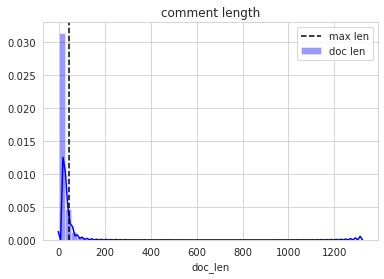

In [3]:
label_names = ["is_toxic"]
y_train = data[label_names].values


data['doc_len'] = data['message'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(data['doc_len'].mean() + data['doc_len'].std()).astype(int)

sns.distplot(data['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('comment length'); plt.legend()
plt.show()

In [4]:
from sklearn.utils import shuffle 

raw_docs_train = data['message'].tolist()
#raw_docs_test = test_data['message'].tolist() 
num_classes = len(label_names)

print("pre-processing train data...")

processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))
#end for
'''
processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))
#end for
'''


print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train )  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
#word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
#word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

  2%|▏         | 434/19571 [00:00<00:04, 4336.86it/s]

pre-processing train data...


100%|██████████| 19571/19571 [00:03<00:00, 6508.02it/s]


tokenizing input data...
dictionary size:  16808


In [5]:
#training params
batch_size = 256 
num_epochs = 40

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

In [6]:
from keras.layers import BatchNormalization
import tensorflow as tf
es_callback = EarlyStopping(monitor='val_loss', patience=3)

In [7]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

In [8]:

max_features =50000
nb_words=50000
embedding_dim =300
sequence_length = 100


#import k-fold
from sklearn.model_selection import KFold
num_folds = 10

run_precision = []
run_recall = []
run_f1score = []
run_accuracy = []

In [9]:
print('loading word embeddings...')

embeddings_index = {}
f = codecs.open('../Embeddings/crawl-300d-2M.vec', encoding='utf-8')

for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('found %s word vectors' % len(embeddings_index))

1094it [00:00, 10935.89it/s]

loading word embeddings...


2000005it [02:05, 15952.35it/s]

found 1999997 word vectors


In [10]:
#embedding matrix

print('preparing embedding matrix...')

words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 5258


In [12]:
print("sample words not found: ", np.random.choice(words_not_found, 10))


sample words not found:  ['isfloat' 'routerinterface' 'ofswitch' 'commoncppextension'
 'drivermanager' 'basetasktestcase' 'trailinggarbage' 'assignmenttype'
 'issamereg' 'hascurrentmethodinput']


In [13]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle=False, random_state=125)
from keras.callbacks import EarlyStopping
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import  precision_score
from sklearn.metrics import  f1_score

/home/amiangshu/anaconda3/envs/toxicJAY/lib/python3.6/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [14]:
lstm_run_precision = []
lstm_run_recall = []
lstm_run_f1score = []
lstm_run_accuracy = []

In [15]:
#only LSTM

from keras.layers import BatchNormalization
import tensorflow as tf


#max_features =22248
#nb_words=22248
embedding_dim =300
sequence_length = 100

def LSTM_model():
    model =  keras.Sequential()
    #model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    #embeddings_regularizer = regularizers.l2(0.005))) 
    model.add( keras.layers.Embedding(nb_words,embed_dim,input_length=max_seq_len,weights=[embedding_matrix],trainable=False))
    model.add( keras.layers.Dropout(0.4))

    model.add( keras.layers.LSTM(embedding_dim,dropout=0.2, recurrent_dropout=0.2,return_sequences=True,\
                                                             kernel_regularizer=regularizers.l2(0.005),\
                                                             bias_regularizer=regularizers.l2(0.005)))

    model.add( keras.layers.Flatten())

    model.add( keras.layers.Dense(512, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
    model.add( keras.layers.Dropout(0.4))

    model.add( keras.layers.Dense(8, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
    model.add( keras.layers.Dropout(0.4))


    model.add( keras.layers.Dense(1,activation='sigmoid'))
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(1e-3),metrics=['acc'])
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 43, 300)           5042700   
_________________________________________________________________
dropout_1 (Dropout)          (None, 43, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 43, 300)           721200    
_________________________________________________________________
flatten_1 (Flatten)          (None, 12900)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               6605312   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                

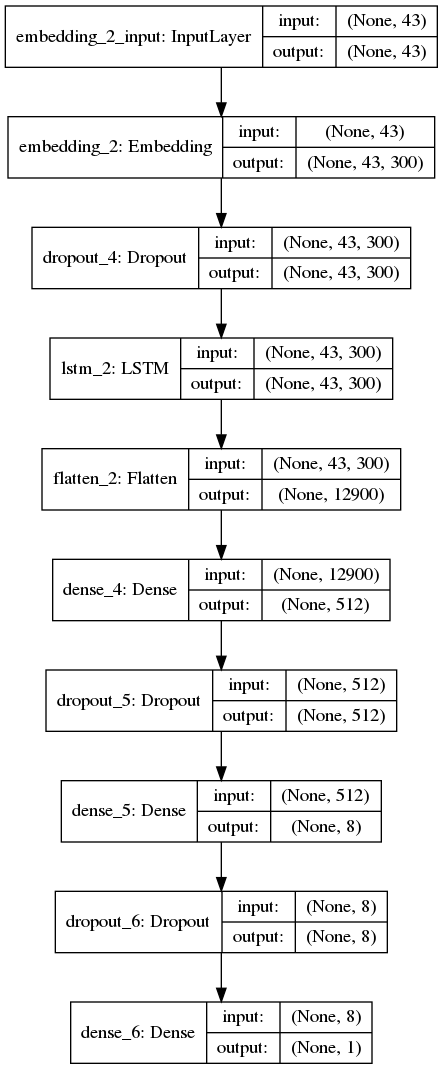

In [16]:
LSTM_model().summary()
plot_model(LSTM_model(), to_file='LSTMmodel.png', show_shapes=True, show_layer_names=True)



Fold  1
Train on 15655 samples, validate on 1958 samples
Epoch 1/40
15655/15655 [==============================] - 3s 183us/step - loss: 2.8897 - accuracy: 0.8263 - val_loss: 1.8627 - val_accuracy: 0.8555
Epoch 2/40
15655/15655 [==============================] - 2s 117us/step - loss: 1.7355 - accuracy: 0.8417 - val_loss: 1.5564 - val_accuracy: 0.8830
Epoch 3/40
15655/15655 [==============================] - 2s 124us/step - loss: 1.5033 - accuracy: 0.8517 - val_loss: 1.3469 - val_accuracy: 0.9086
Epoch 4/40
15655/15655 [==============================] - 2s 137us/step - loss: 1.3261 - accuracy: 0.8570 - val_loss: 1.1937 - val_accuracy: 0.9081
Epoch 5/40
15655/15655 [==============================] - 2s 123us/step - loss: 1.1790 - accuracy: 0.8650 - val_loss: 1.0529 - val_accuracy: 0.9203
Epoch 6/40
15655/15655 [==============================] - 2s 126us/step - loss: 1.0477 - accuracy: 0.9011 - val_loss: 0.9376 - val_accuracy: 0.9254
Epoch 7/40
15655/15655 [==============================

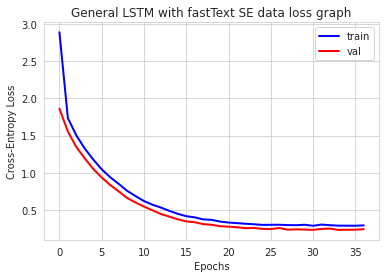

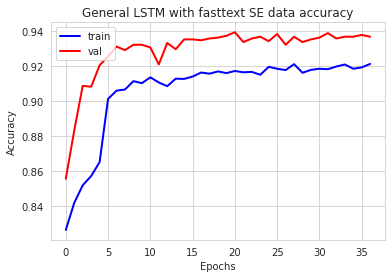

              precision    recall  f1-score   support

           0       0.92      0.93      0.92      1478
           1       0.77      0.76      0.77       480

    accuracy                           0.89      1958
   macro avg       0.85      0.85      0.85      1958
weighted avg       0.89      0.89      0.89      1958


Fold  2
Train on 15656 samples, validate on 1958 samples
Epoch 1/40
15656/15656 [==============================] - 2s 154us/step - loss: 2.8760 - accuracy: 0.8179 - val_loss: 1.8386 - val_accuracy: 0.8611
Epoch 2/40
15656/15656 [==============================] - 2s 112us/step - loss: 1.7179 - accuracy: 0.8525 - val_loss: 1.5401 - val_accuracy: 0.8963
Epoch 3/40
15656/15656 [==============================] - 2s 113us/step - loss: 1.4920 - accuracy: 0.8660 - val_loss: 1.3585 - val_accuracy: 0.9091
Epoch 4/40
15656/15656 [==============================] - 2s 113us/step - loss: 1.3243 - accuracy: 0.8744 - val_loss: 1.1924 - val_accuracy: 0.9244
Epoch 5/40
15656/15656 

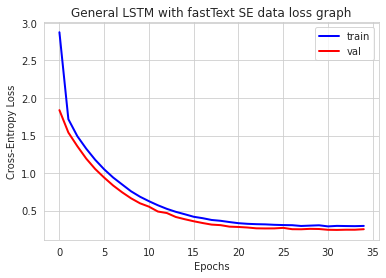

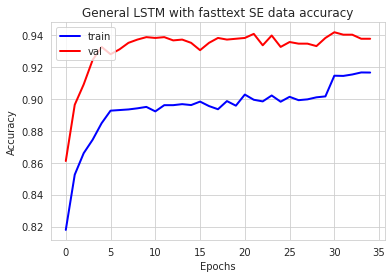

              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1639
           1       0.72      0.60      0.66       318

    accuracy                           0.90      1957
   macro avg       0.83      0.78      0.80      1957
weighted avg       0.89      0.90      0.89      1957


Fold  3
Train on 15656 samples, validate on 1958 samples
Epoch 1/40
15656/15656 [==============================] - 2s 153us/step - loss: 2.8621 - accuracy: 0.8194 - val_loss: 1.8220 - val_accuracy: 0.8728
Epoch 2/40
15656/15656 [==============================] - 2s 113us/step - loss: 1.7173 - accuracy: 0.8526 - val_loss: 1.5450 - val_accuracy: 0.8973
Epoch 3/40
15656/15656 [==============================] - 2s 112us/step - loss: 1.4987 - accuracy: 0.8723 - val_loss: 1.3511 - val_accuracy: 0.9045
Epoch 4/40
15656/15656 [==============================] - 2s 114us/step - loss: 1.3369 - accuracy: 0.8874 - val_loss: 1.1936 - val_accuracy: 0.9198
Epoch 5/40
15656/15656 

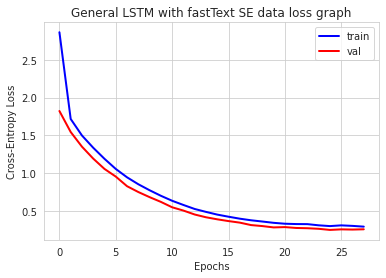

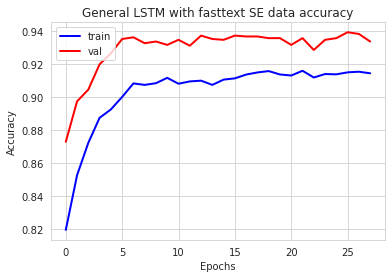

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1582
           1       0.78      0.66      0.72       375

    accuracy                           0.90      1957
   macro avg       0.85      0.81      0.83      1957
weighted avg       0.90      0.90      0.90      1957


Fold  4
Train on 15656 samples, validate on 1958 samples
Epoch 1/40
15656/15656 [==============================] - 2s 157us/step - loss: 2.8622 - accuracy: 0.8342 - val_loss: 1.8140 - val_accuracy: 0.8713
Epoch 2/40
15656/15656 [==============================] - 2s 121us/step - loss: 1.7017 - accuracy: 0.8621 - val_loss: 1.5229 - val_accuracy: 0.8922
Epoch 3/40
15656/15656 [==============================] - 2s 112us/step - loss: 1.4770 - accuracy: 0.8818 - val_loss: 1.3319 - val_accuracy: 0.9045
Epoch 4/40
15656/15656 [==============================] - 2s 112us/step - loss: 1.3181 - accuracy: 0.8877 - val_loss: 1.1842 - val_accuracy: 0.9157
Epoch 5/40
15656/15656 

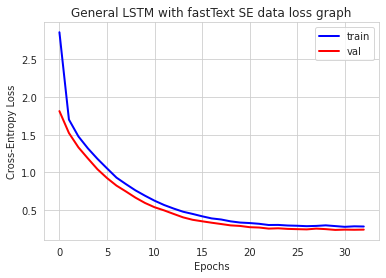

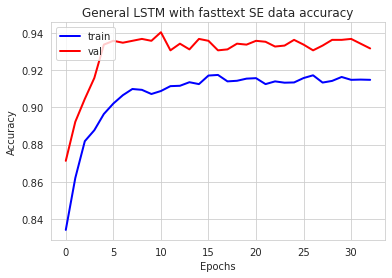

              precision    recall  f1-score   support

           0       0.89      0.90      0.90      1214
           1       0.84      0.83      0.83       743

    accuracy                           0.87      1957
   macro avg       0.87      0.86      0.86      1957
weighted avg       0.87      0.87      0.87      1957


Fold  5
Train on 15656 samples, validate on 1958 samples
Epoch 1/40
15656/15656 [==============================] - 2s 146us/step - loss: 2.8875 - accuracy: 0.8226 - val_loss: 1.8387 - val_accuracy: 0.8611
Epoch 2/40
15656/15656 [==============================] - 2s 111us/step - loss: 1.7199 - accuracy: 0.8601 - val_loss: 1.5303 - val_accuracy: 0.8907
Epoch 3/40
15656/15656 [==============================] - 2s 113us/step - loss: 1.5078 - accuracy: 0.8728 - val_loss: 1.3437 - val_accuracy: 0.9035
Epoch 4/40
15656/15656 [==============================] - 2s 114us/step - loss: 1.3430 - accuracy: 0.8818 - val_loss: 1.1948 - val_accuracy: 0.9122
Epoch 5/40
15656/15656 

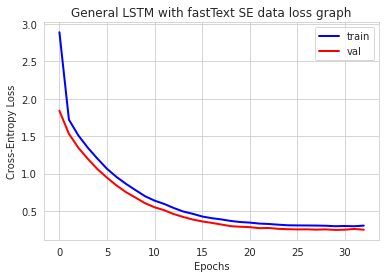

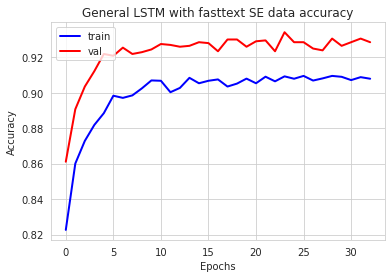

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1558
           1       0.93      0.71      0.81       399

    accuracy                           0.93      1957
   macro avg       0.93      0.85      0.88      1957
weighted avg       0.93      0.93      0.93      1957


Fold  6
Train on 15656 samples, validate on 1958 samples
Epoch 1/40
15656/15656 [==============================] - 2s 149us/step - loss: 2.8944 - accuracy: 0.8194 - val_loss: 1.8536 - val_accuracy: 0.8590
Epoch 2/40
15656/15656 [==============================] - 2s 114us/step - loss: 1.7301 - accuracy: 0.8464 - val_loss: 1.5643 - val_accuracy: 0.8769
Epoch 3/40
15656/15656 [==============================] - 2s 118us/step - loss: 1.5126 - accuracy: 0.8570 - val_loss: 1.3665 - val_accuracy: 0.8943
Epoch 4/40
15656/15656 [==============================] - 2s 119us/step - loss: 1.3519 - accuracy: 0.8642 - val_loss: 1.2150 - val_accuracy: 0.8989
Epoch 5/40
15656/15656 

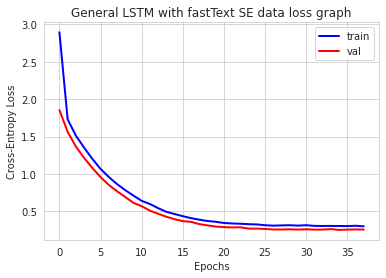

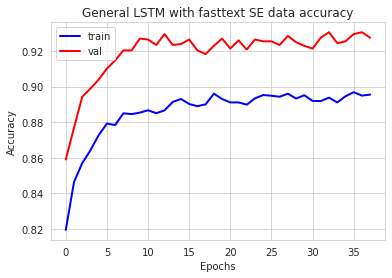

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1756
           1       0.82      0.84      0.83       201

    accuracy                           0.96      1957
   macro avg       0.90      0.91      0.90      1957
weighted avg       0.96      0.96      0.96      1957


Fold  7
Train on 15656 samples, validate on 1958 samples
Epoch 1/40
15656/15656 [==============================] - 2s 148us/step - loss: 2.9144 - accuracy: 0.8224 - val_loss: 1.8255 - val_accuracy: 0.8672
Epoch 2/40
15656/15656 [==============================] - 2s 114us/step - loss: 1.7409 - accuracy: 0.8563 - val_loss: 1.5312 - val_accuracy: 0.8815
Epoch 3/40
15656/15656 [==============================] - 2s 112us/step - loss: 1.5277 - accuracy: 0.8707 - val_loss: 1.3615 - val_accuracy: 0.8968
Epoch 4/40
15656/15656 [==============================] - 2s 112us/step - loss: 1.3425 - accuracy: 0.8867 - val_loss: 1.1984 - val_accuracy: 0.9152
Epoch 5/40
15656/15656 

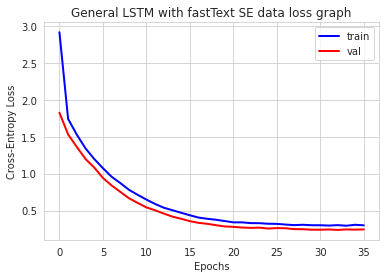

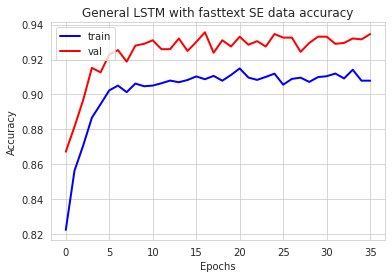

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1585
           1       0.84      0.81      0.82       372

    accuracy                           0.93      1957
   macro avg       0.90      0.88      0.89      1957
weighted avg       0.93      0.93      0.93      1957


Fold  8
Train on 15656 samples, validate on 1958 samples
Epoch 1/40
15656/15656 [==============================] - 2s 145us/step - loss: 2.8980 - accuracy: 0.8268 - val_loss: 1.8371 - val_accuracy: 0.8687
Epoch 2/40
15656/15656 [==============================] - 2s 112us/step - loss: 1.7184 - accuracy: 0.8505 - val_loss: 1.5185 - val_accuracy: 0.8958
Epoch 3/40
15656/15656 [==============================] - 2s 112us/step - loss: 1.5052 - accuracy: 0.8636 - val_loss: 1.3475 - val_accuracy: 0.8933
Epoch 4/40
15656/15656 [==============================] - 2s 112us/step - loss: 1.3325 - accuracy: 0.8765 - val_loss: 1.1843 - val_accuracy: 0.9127
Epoch 5/40
15656/15656 

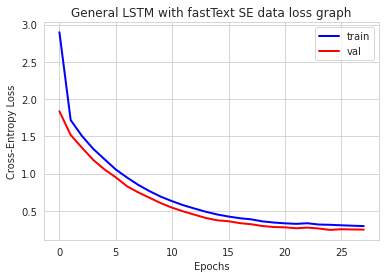

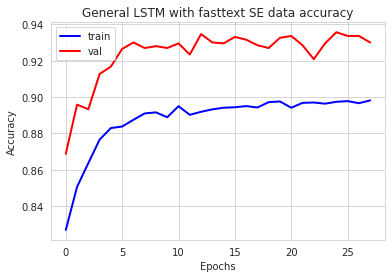

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1435
           1       0.87      0.89      0.88       522

    accuracy                           0.93      1957
   macro avg       0.91      0.92      0.92      1957
weighted avg       0.93      0.93      0.93      1957


Fold  9
Train on 15656 samples, validate on 1958 samples
Epoch 1/40
15656/15656 [==============================] - 2s 149us/step - loss: 2.9170 - accuracy: 0.8180 - val_loss: 1.8269 - val_accuracy: 0.8636
Epoch 2/40
15656/15656 [==============================] - 2s 114us/step - loss: 1.7347 - accuracy: 0.8521 - val_loss: 1.5254 - val_accuracy: 0.8922
Epoch 3/40
15656/15656 [==============================] - 2s 128us/step - loss: 1.5257 - accuracy: 0.8684 - val_loss: 1.3627 - val_accuracy: 0.8938
Epoch 4/40
15656/15656 [==============================] - 2s 134us/step - loss: 1.3549 - accuracy: 0.8837 - val_loss: 1.2251 - val_accuracy: 0.9030
Epoch 5/40
15656/15656 

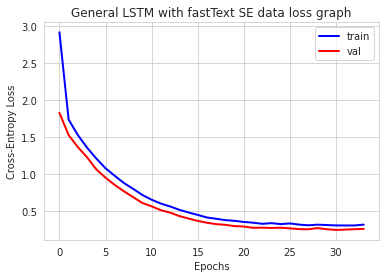

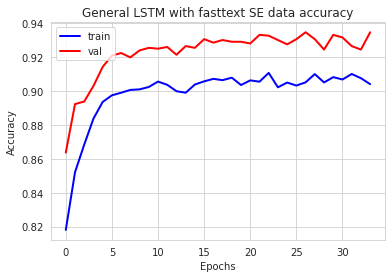

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1669
           1       0.94      0.75      0.83       288

    accuracy                           0.96      1957
   macro avg       0.95      0.87      0.90      1957
weighted avg       0.96      0.96      0.95      1957


Fold  10
Train on 15656 samples, validate on 1958 samples
Epoch 1/40
15656/15656 [==============================] - 2s 144us/step - loss: 2.9110 - accuracy: 0.8033 - val_loss: 1.8291 - val_accuracy: 0.8371
Epoch 2/40
15656/15656 [==============================] - 2s 109us/step - loss: 1.7638 - accuracy: 0.8485 - val_loss: 1.5439 - val_accuracy: 0.8830
Epoch 3/40
15656/15656 [==============================] - 2s 110us/step - loss: 1.5463 - accuracy: 0.8673 - val_loss: 1.3803 - val_accuracy: 0.8790
Epoch 4/40
15656/15656 [==============================] - 2s 115us/step - loss: 1.3806 - accuracy: 0.8811 - val_loss: 1.1968 - val_accuracy: 0.9101
Epoch 5/40
15656/15656

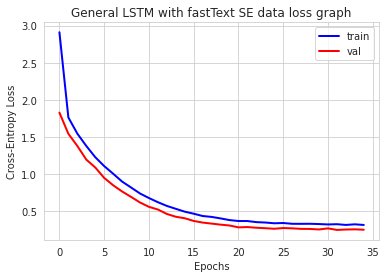

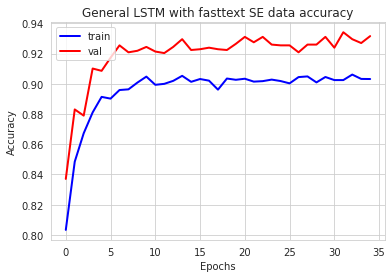

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1903
           1       0.70      0.81      0.75        54

    accuracy                           0.99      1957
   macro avg       0.85      0.90      0.87      1957
weighted avg       0.99      0.99      0.99      1957



In [17]:
count = 1

for train_index, test_index in kf.split(word_seq_train):
    x_trn, x_tst = word_seq_train[train_index], word_seq_train[test_index]
    y_trn, y_tst = y_train[train_index], y_train[test_index]
    
    x_new_train, x_val, y_new_train, y_val= train_test_split(x_trn, y_trn, test_size=0.11115, random_state=125)
    
    print("\nFold ", count)
    lstm_model=LSTM_model()

    #model_lstm_fasttext=model_with_embedding()
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    
    history =lstm_model.fit( x_new_train, y_new_train, batch_size=256,
          epochs=num_epochs, validation_data=(x_val, y_val), callbacks=[es_callback], shuffle=False)
    
    _, train_acc =lstm_model.evaluate(x_new_train,  y_new_train, verbose=0)
    _, val_acc =  lstm_model.evaluate(x_val, y_val, verbose=0)
    print('Train: %.3f, Test: %.3f' % (train_acc, val_acc))
    
    
    plt.figure()
    plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
    plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
    plt.title('General LSTM with fastText SE data loss graph')
    plt.xlabel('Epochs')
    plt.ylabel('Cross-Entropy Loss')
    plt.legend(loc='upper right')
    #plt.savefig('LSTM with fasttext SE data loss graph.png')
    plt.show()
    
    plt.figure()
    plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
    plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
    plt.title('General LSTM with fasttext SE data accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    #plt.savefig('LSTM with fasttext SE data accuracy graph.png')
    plt.show()
    
    
    y_pred = lstm_model.predict(x_tst)
    y_pred = (y_pred >= 0.5)
 
    
    from sklearn import metrics
    print(metrics.classification_report(y_tst, y_pred))
    
    lstm_precision = precision_score(y_tst, y_pred, pos_label=1)
    lstm_recall = recall_score(y_tst, y_pred, pos_label=1)
    lstm_f1score = f1_score(y_tst, y_pred, pos_label=1)
    lstm_accuracy = accuracy_score(y_tst, y_pred)

    lstm_run_accuracy.append(lstm_accuracy)
    lstm_run_f1score.append(lstm_f1score)
    lstm_run_precision.append(lstm_precision)
    lstm_run_recall.append(lstm_recall)
    
    count = count+1

In [18]:
from statistics import mean
print("....... General LSTM Model................")
print(".......Precision........", "........Recall........","........F1...........", ".....Accuracy.......")

print(mean(lstm_run_precision),mean(lstm_run_recall),mean(lstm_run_f1score),mean(lstm_run_accuracy))

....... General LSTM Model................
.......Precision........ ........Recall........ ........F1........... .....Accuracy.......
0.8200135950177807 0.7664787030963071 0.7893445982760008 0.9259128202210655


In [62]:

dpcnn_run_precision = []
dpcnn_run_recall = []
dpcnn_run_f1score = []
dpcnn_run_accuracy = []


# wrote out all the blocks instead of looping for simplicity
filter_nr = 64
filter_size = 3
#max_pool_size = 3
max_pool_size = 1
max_pool_strides = 2
dense_nr = 256
spatial_dropout = 0.2
dense_dropout = 0.5
train_embed = False
conv_kern_reg = regularizers.l2(0.00001)
conv_bias_reg = regularizers.l2(0.00001)


In [63]:

maxlen = 43
embed_size = 300
train_embed = False
max_features =16809


from keras.models import Model

def get_model_DPCNN():
    #deinfe model
    comment = keras.layers.Input(shape=(maxlen,))
    emb_comment = keras.layers.Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=train_embed)(comment)
    emb_comment = keras.layers.SpatialDropout1D(spatial_dropout)(emb_comment)

    block1 = keras.layers.Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear',
                kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(emb_comment)
    block1 = keras.layers.BatchNormalization()(block1)
    block1 = keras.layers.PReLU()(block1)
    block1 = keras.layers.Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear',
                kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block1)
    block1 = keras.layers.BatchNormalization()(block1)
    block1 = keras.layers.PReLU()(block1)

# we pass embedded comment through conv1d with filter size 1 because it needs to have the same shape as block output
# if you choose filter_nr = embed_size (300 in this case) you don't have to do this part and can add emb_comment directly to block1_output
    resize_emb = keras.layers.Conv1D(filter_nr, kernel_size=1, padding='same', activation='linear',
                    kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(emb_comment)
    resize_emb = keras.layers.PReLU()(resize_emb)

    block1_output = keras.layers.add([block1, resize_emb])
    block1_output = keras.layers.MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block1_output)

    block2 = keras.layers.Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear',
                kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block1_output)
    block2 = keras.layers.BatchNormalization()(block2)
    block2 = keras.layers.PReLU()(block2)
    block2 = keras.layers.Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear',
                kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block2)
    block2 = keras.layers.BatchNormalization()(block2)
    block2 = keras.layers.PReLU()(block2)

    block2_output = keras.layers.add([block2, block1_output])
    block2_output = keras.layers.MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block2_output)

    block3 = keras.layers.Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear',
                kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block2_output)
    block3 = keras.layers.BatchNormalization()(block3)
    block3 = keras.layers.PReLU()(block3)
    block3 = keras.layers.Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear',
                kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block3)
    block3 = keras.layers.BatchNormalization()(block3)
    block3 = keras.layers.PReLU()(block3)

    block3_output = keras.layers.add([block3, block2_output])
    block3_output = keras.layers.MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block3_output)

    block4 = keras.layers.Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear',
                kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block3_output)
    block4 = keras.layers.BatchNormalization()(block4)
    block4 = keras.layers.PReLU()(block4)
    block4 = keras.layers.Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear',
                kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block4)
    block4 = keras.layers.BatchNormalization()(block4)
    block4 = keras.layers.PReLU()(block4)

    block4_output = keras.layers.add([block4, block3_output])
    block4_output = keras.layers.MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block4_output)

    block5 = keras.layers.Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear',
                kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block4_output)
    block5 = keras.layers.BatchNormalization()(block5)
    block5 = keras.layers.PReLU()(block5)
    block5 = keras.layers.Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear',
                kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block5)
    block5 = keras.layers.BatchNormalization()(block5)
    block5 = keras.layers.PReLU()(block5)

    block5_output = keras.layers.add([block5, block4_output])
    block5_output = keras.layers.MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block5_output)

    block6 = keras.layers.Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear',
                kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block5_output)
    block6 = keras.layers.BatchNormalization()(block6)
    block6 = keras.layers.PReLU()(block6)
    block6 = keras.layers.Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear',
                kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block6)
    block6 = keras.layers.BatchNormalization()(block6)
    block6 = keras.layers.PReLU()(block6)

    block6_output = keras.layers.add([block6, block5_output])
    block6_output = keras.layers.MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block6_output)

    block7 = keras.layers.Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear',
                kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block6_output)
    block7 = keras.layers.BatchNormalization()(block7)
    block7 = keras.layers.PReLU()(block7)
    block7 = keras.layers.Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear',
                kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block7)
    block7 = keras.layers.BatchNormalization()(block7)
    block7 = keras.layers.PReLU()(block7)

    block7_output = keras.layers.add([block7, block6_output])
    output = keras.layers.GlobalMaxPooling1D()(block7_output)

    output = keras.layers.Dense(dense_nr, activation='linear')(output)
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.PReLU()(output)
    output = keras.layers.Dropout(dense_dropout)(output)

### one layer
    output = keras.layers.Dense(1, activation='sigmoid')(output)

    model = Model(comment, output)

    model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])
    
    return model



In [64]:
dpcnn_model= get_model_DPCNN()


In [65]:
dpcnn_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 43)           0                                            
__________________________________________________________________________________________________
embedding_25 (Embedding)        (None, 43, 300)      5042700     input_15[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_11 (SpatialDr (None, 43, 300)      0           embedding_25[0][0]               
__________________________________________________________________________________________________
conv1d_101 (Conv1D)             (None, 43, 64)       57664       spatial_dropout1d_11[0][0]       
____________________________________________________________________________________________

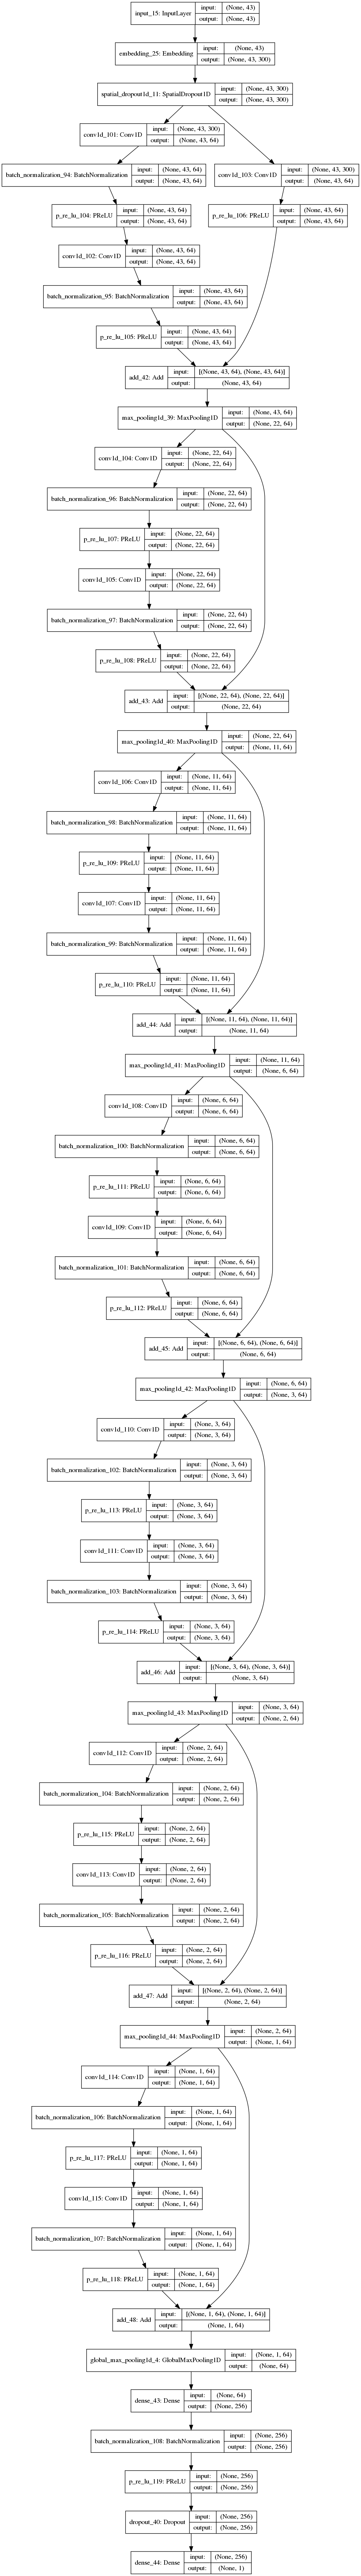

In [66]:
plot_model(dpcnn_model, to_file='DPCNN.png', show_shapes=True, show_layer_names=True)


In [68]:
'''
count = 1

for train_index, test_index in kf.split(word_seq_train):
    x_trn, x_tst = word_seq_train[train_index], word_seq_train[test_index]
    y_trn, y_tst = y_train[train_index], y_train[test_index]
    
    x_new_train, x_val, y_new_train, y_val= train_test_split(x_trn, y_trn, test_size=0.11115, random_state=125)
    
    print("\nFold ", count)
    dpcnn_model= get_model_DPCNN()

    #model_lstm_fasttext=model_with_embedding()
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    
    history =dpcnn_model.fit( x_new_train, y_new_train, batch_size=256,
          epochs=num_epochs, validation_data=(x_val, y_val), callbacks=[es_callback], shuffle=False)
    
    _, train_acc =dpcnn_model.evaluate(x_new_train,  y_new_train, verbose=0)
    _, val_acc =  dpcnn_model.evaluate(x_val, y_val, verbose=0)
    print('Train: %.3f, Test: %.3f' % (train_acc, val_acc))
    
    
    plt.figure()
    plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
    plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
    plt.title('DPCNN with fastText SE data loss graph')
    plt.xlabel('Epochs')
    plt.ylabel('Cross-Entropy Loss')
    plt.legend(loc='upper right')
    #plt.savefig('LSTM with fasttext SE data loss graph.png')
    plt.show()
    
    plt.figure()
    plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
    plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
    plt.title('DPCNN with fasttext SE data accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    #plt.savefig('LSTM with fasttext SE data accuracy graph.png')
    plt.show()
    
    
    y_pred = dpcnn_model.predict(x_tst)
    y_pred = (y_pred >= 0.5)
 
    
    from sklearn import metrics
    print(metrics.classification_report(y_tst, y_pred))
    
    dpcnn_precision = precision_score(y_tst, y_pred, pos_label=1)
    dpcnn_recall = recall_score(y_tst, y_pred, pos_label=1)
    dpcnn_f1score = f1_score(y_tst, y_pred, pos_label=1)
    dpcnn_accuracy = accuracy_score(y_tst, y_pred)

    dpcnn_run_accuracy.append(lstm_accuracy)
    dpcnn_run_f1score.append(lstm_f1score)
    dpcnn_run_precision.append(lstm_precision)
    dpcnn_run_recall.append(lstm_recall)
    
    count = count+1
'''

'\ncount = 1\n\nfor train_index, test_index in kf.split(word_seq_train):\n    x_trn, x_tst = word_seq_train[train_index], word_seq_train[test_index]\n    y_trn, y_tst = y_train[train_index], y_train[test_index]\n    \n    x_new_train, x_val, y_new_train, y_val= train_test_split(x_trn, y_trn, test_size=0.11115, random_state=125)\n    \n    print("\nFold ", count)\n    dpcnn_model= get_model_DPCNN()\n\n    #model_lstm_fasttext=model_with_embedding()\n    \n    es = EarlyStopping(monitor=\'val_loss\', mode=\'min\', verbose=1)\n    \n    history =dpcnn_model.fit( x_new_train, y_new_train, batch_size=256,\n          epochs=num_epochs, validation_data=(x_val, y_val), callbacks=[es_callback], shuffle=False)\n    \n    _, train_acc =dpcnn_model.evaluate(x_new_train,  y_new_train, verbose=0)\n    _, val_acc =  dpcnn_model.evaluate(x_val, y_val, verbose=0)\n    print(\'Train: %.3f, Test: %.3f\' % (train_acc, val_acc))\n    \n    \n    plt.figure()\n    plt.plot(history.history[\'loss\'], lw=2.0,

In [12]:
from keras.layers import BatchNormalization
import tensorflow as tf


#max_features =22248
#nb_words=22248
embedding_dim =300
sequence_length = 100

def BiLSTM():
    #model = tf.keras.Sequential()
    model = keras.Sequential()
    model.add(keras.layers.Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix],trainable=False))
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
    model.add(keras.layers.Dense(32,activation='relu'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [13]:
bilstm_model=BiLSTM()

bilstm_model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 43, 300)           5042700   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                85248     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 5,130,061
Trainable params: 87,361
Non-trainable params: 5,042,700
_________________________________________________________________


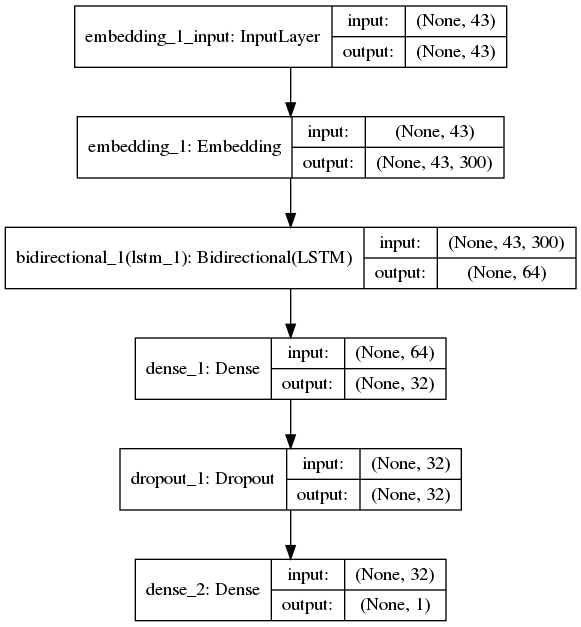

In [14]:
plot_model(bilstm_model, to_file='BiLSTM.png', show_shapes=True, show_layer_names=True)


/home/amiangshu/anaconda3/envs/toxicJAY/lib/python3.6/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



Fold  1
Train on 15655 samples, validate on 1958 samples
Epoch 1/40
15655/15655 [==============================] - 3s 210us/step - loss: 0.4950 - accuracy: 0.7962 - val_loss: 0.3153 - val_accuracy: 0.8606
Epoch 2/40
15655/15655 [==============================] - 2s 135us/step - loss: 0.2936 - accuracy: 0.8632 - val_loss: 0.2427 - val_accuracy: 0.8979
Epoch 3/40
15655/15655 [==============================] - 2s 136us/step - loss: 0.2339 - accuracy: 0.9029 - val_loss: 0.2008 - val_accuracy: 0.9198
Epoch 4/40
15655/15655 [==============================] - 2s 135us/step - loss: 0.1917 - accuracy: 0.9253 - val_loss: 0.1816 - val_accuracy: 0.9265
Epoch 5/40
15655/15655 [==============================] - 2s 137us/step - loss: 0.1648 - accuracy: 0.9362 - val_loss: 0.1692 - val_accuracy: 0.9305
Epoch 6/40
15655/15655 [==============================] - 2s 137us/step - loss: 0.1491 - accuracy: 0.9439 - val_loss: 0.1632 - val_accuracy: 0.9341
Epoch 7/40
15655/15655 [==============================

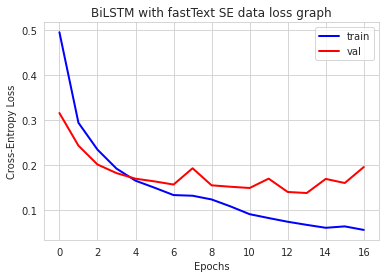

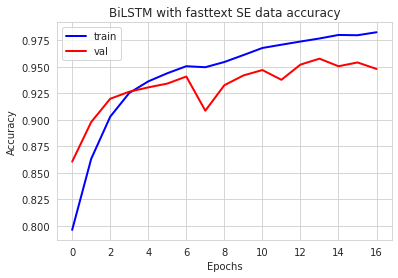

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      1478
           1       0.86      0.64      0.73       480

    accuracy                           0.89      1958
   macro avg       0.87      0.80      0.83      1958
weighted avg       0.88      0.89      0.88      1958


Fold  2
Train on 15656 samples, validate on 1958 samples
Epoch 1/40
15656/15656 [==============================] - 3s 180us/step - loss: 0.4453 - accuracy: 0.8132 - val_loss: 0.3507 - val_accuracy: 0.8299
Epoch 2/40
15656/15656 [==============================] - 2s 132us/step - loss: 0.2802 - accuracy: 0.8757 - val_loss: 0.2386 - val_accuracy: 0.9086
Epoch 3/40
15656/15656 [==============================] - 2s 131us/step - loss: 0.2186 - accuracy: 0.9136 - val_loss: 0.2104 - val_accuracy: 0.9183
Epoch 4/40
15656/15656 [==============================] - 2s 130us/step - loss: 0.1871 - accuracy: 0.9292 - val_loss: 0.2019 - val_accuracy: 0.9259
Epoch 5/40
15656/15656 

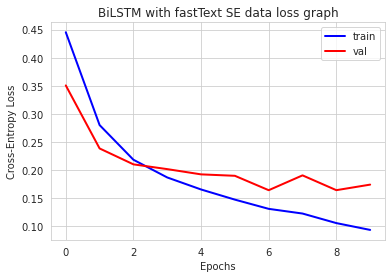

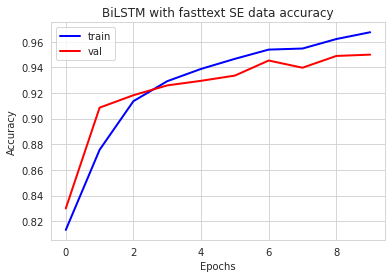

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1639
           1       0.77      0.62      0.69       318

    accuracy                           0.91      1957
   macro avg       0.85      0.79      0.82      1957
weighted avg       0.90      0.91      0.90      1957


Fold  3
Train on 15656 samples, validate on 1958 samples
Epoch 1/40
15656/15656 [==============================] - 3s 181us/step - loss: 0.4582 - accuracy: 0.8133 - val_loss: 0.3234 - val_accuracy: 0.8524
Epoch 2/40
15656/15656 [==============================] - 2s 131us/step - loss: 0.2708 - accuracy: 0.8827 - val_loss: 0.2255 - val_accuracy: 0.9091
Epoch 3/40
15656/15656 [==============================] - 2s 131us/step - loss: 0.2074 - accuracy: 0.9214 - val_loss: 0.1937 - val_accuracy: 0.9280
Epoch 4/40
15656/15656 [==============================] - 2s 132us/step - loss: 0.1769 - accuracy: 0.9318 - val_loss: 0.1835 - val_accuracy: 0.9362
Epoch 5/40
15656/15656 

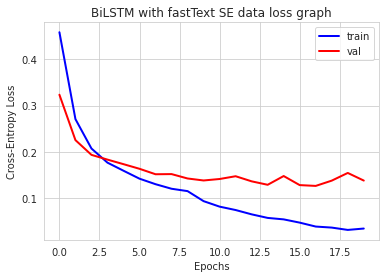

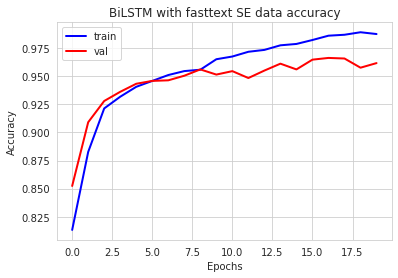

              precision    recall  f1-score   support

           0       0.93      0.92      0.93      1582
           1       0.69      0.73      0.71       375

    accuracy                           0.89      1957
   macro avg       0.81      0.83      0.82      1957
weighted avg       0.89      0.89      0.89      1957


Fold  4
Train on 15656 samples, validate on 1958 samples
Epoch 1/40
15656/15656 [==============================] - 3s 177us/step - loss: 0.4434 - accuracy: 0.8206 - val_loss: 0.3024 - val_accuracy: 0.8657
Epoch 2/40
15656/15656 [==============================] - 2s 131us/step - loss: 0.2600 - accuracy: 0.8899 - val_loss: 0.2222 - val_accuracy: 0.9101
Epoch 3/40
15656/15656 [==============================] - 2s 131us/step - loss: 0.2042 - accuracy: 0.9214 - val_loss: 0.1956 - val_accuracy: 0.9249
Epoch 4/40
15656/15656 [==============================] - 2s 130us/step - loss: 0.1755 - accuracy: 0.9341 - val_loss: 0.1833 - val_accuracy: 0.9326
Epoch 5/40
15656/15656 

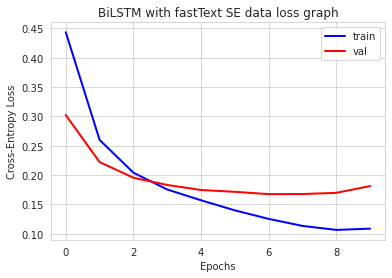

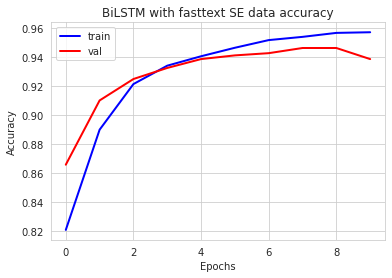

              precision    recall  f1-score   support

           0       0.95      0.88      0.91      1214
           1       0.83      0.92      0.87       743

    accuracy                           0.90      1957
   macro avg       0.89      0.90      0.89      1957
weighted avg       0.90      0.90      0.90      1957


Fold  5
Train on 15656 samples, validate on 1958 samples
Epoch 1/40
15656/15656 [==============================] - 3s 166us/step - loss: 0.4739 - accuracy: 0.7893 - val_loss: 0.3193 - val_accuracy: 0.8529
Epoch 2/40
15656/15656 [==============================] - 2s 129us/step - loss: 0.2828 - accuracy: 0.8765 - val_loss: 0.2452 - val_accuracy: 0.9019
Epoch 3/40
15656/15656 [==============================] - 2s 128us/step - loss: 0.2289 - accuracy: 0.9097 - val_loss: 0.2170 - val_accuracy: 0.9203
Epoch 4/40
15656/15656 [==============================] - 2s 128us/step - loss: 0.1981 - accuracy: 0.9234 - val_loss: 0.2046 - val_accuracy: 0.9259
Epoch 5/40
15656/15656 

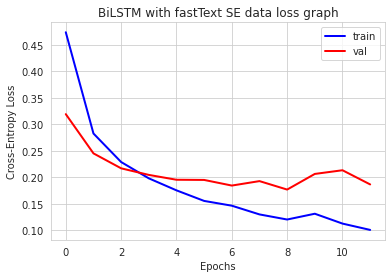

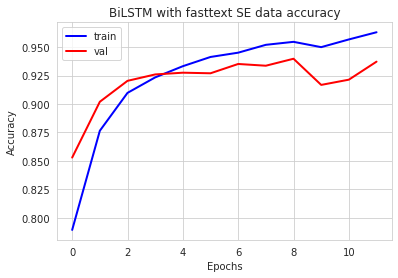

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1558
           1       0.91      0.91      0.91       399

    accuracy                           0.96      1957
   macro avg       0.94      0.94      0.94      1957
weighted avg       0.96      0.96      0.96      1957


Fold  6
Train on 15656 samples, validate on 1958 samples
Epoch 1/40
15656/15656 [==============================] - 3s 169us/step - loss: 0.4959 - accuracy: 0.7936 - val_loss: 0.3420 - val_accuracy: 0.8330
Epoch 2/40
15656/15656 [==============================] - 2s 132us/step - loss: 0.2969 - accuracy: 0.8701 - val_loss: 0.2530 - val_accuracy: 0.8999
Epoch 3/40
15656/15656 [==============================] - 2s 133us/step - loss: 0.2352 - accuracy: 0.9051 - val_loss: 0.2247 - val_accuracy: 0.9132
Epoch 4/40
15656/15656 [==============================] - 2s 133us/step - loss: 0.2001 - accuracy: 0.9220 - val_loss: 0.2054 - val_accuracy: 0.9259
Epoch 5/40
15656/15656 

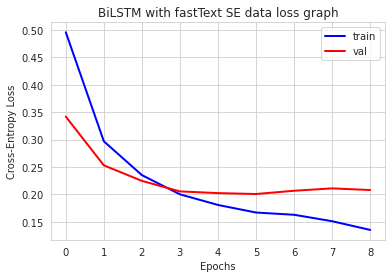

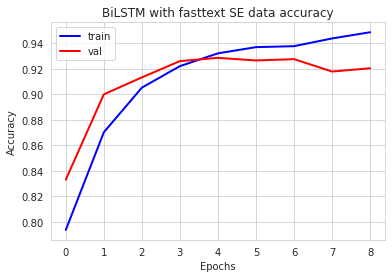

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1756
           1       0.80      0.91      0.85       201

    accuracy                           0.97      1957
   macro avg       0.90      0.94      0.92      1957
weighted avg       0.97      0.97      0.97      1957


Fold  7
Train on 15656 samples, validate on 1958 samples
Epoch 1/40
15656/15656 [==============================] - 3s 167us/step - loss: 0.4874 - accuracy: 0.7938 - val_loss: 0.3145 - val_accuracy: 0.8539
Epoch 2/40
15656/15656 [==============================] - 2s 131us/step - loss: 0.2805 - accuracy: 0.8756 - val_loss: 0.2390 - val_accuracy: 0.8994
Epoch 3/40
15656/15656 [==============================] - 2s 131us/step - loss: 0.2211 - accuracy: 0.9120 - val_loss: 0.2049 - val_accuracy: 0.9229
Epoch 4/40
15656/15656 [==============================] - 2s 131us/step - loss: 0.1933 - accuracy: 0.9261 - val_loss: 0.1989 - val_accuracy: 0.9254
Epoch 5/40
15656/15656 

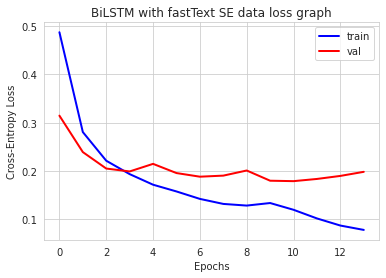

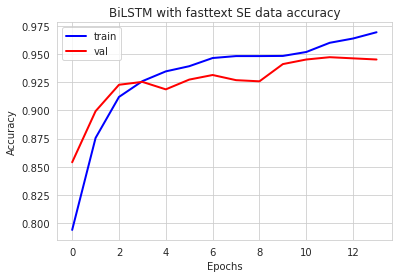

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1585
           1       0.91      0.86      0.88       372

    accuracy                           0.96      1957
   macro avg       0.94      0.92      0.93      1957
weighted avg       0.96      0.96      0.96      1957


Fold  8
Train on 15656 samples, validate on 1958 samples
Epoch 1/40
15656/15656 [==============================] - 3s 168us/step - loss: 0.4351 - accuracy: 0.8223 - val_loss: 0.2922 - val_accuracy: 0.8636
Epoch 2/40
15656/15656 [==============================] - 2s 132us/step - loss: 0.2664 - accuracy: 0.8830 - val_loss: 0.2221 - val_accuracy: 0.9004
Epoch 3/40
15656/15656 [==============================] - 2s 132us/step - loss: 0.2169 - accuracy: 0.9129 - val_loss: 0.1979 - val_accuracy: 0.9208
Epoch 4/40
15656/15656 [==============================] - 2s 132us/step - loss: 0.1888 - accuracy: 0.9265 - val_loss: 0.1813 - val_accuracy: 0.9362
Epoch 5/40
15656/15656 

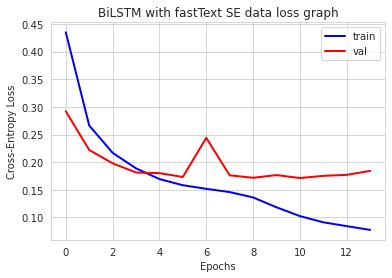

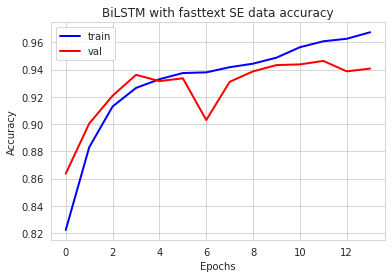

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1435
           1       0.96      0.89      0.92       522

    accuracy                           0.96      1957
   macro avg       0.96      0.94      0.95      1957
weighted avg       0.96      0.96      0.96      1957


Fold  9
Train on 15656 samples, validate on 1958 samples
Epoch 1/40
15656/15656 [==============================] - 3s 164us/step - loss: 0.4734 - accuracy: 0.7967 - val_loss: 0.3059 - val_accuracy: 0.8647
Epoch 2/40
15656/15656 [==============================] - 2s 128us/step - loss: 0.2764 - accuracy: 0.8822 - val_loss: 0.2312 - val_accuracy: 0.9122
Epoch 3/40
15656/15656 [==============================] - 2s 128us/step - loss: 0.2155 - accuracy: 0.9147 - val_loss: 0.2087 - val_accuracy: 0.9208
Epoch 4/40
15656/15656 [==============================] - 2s 128us/step - loss: 0.1857 - accuracy: 0.9270 - val_loss: 0.1956 - val_accuracy: 0.9259
Epoch 5/40
15656/15656 

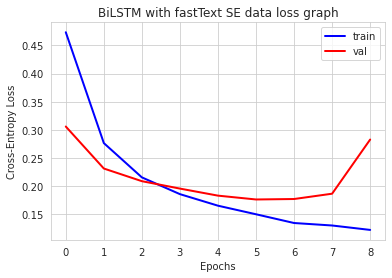

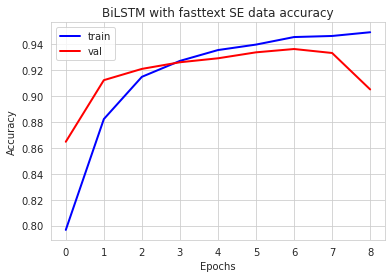

              precision    recall  f1-score   support

           0       0.99      0.93      0.96      1669
           1       0.72      0.96      0.82       288

    accuracy                           0.94      1957
   macro avg       0.86      0.95      0.89      1957
weighted avg       0.95      0.94      0.94      1957


Fold  10
Train on 15656 samples, validate on 1958 samples
Epoch 1/40
15656/15656 [==============================] - 3s 165us/step - loss: 0.4844 - accuracy: 0.7895 - val_loss: 0.3393 - val_accuracy: 0.8453
Epoch 2/40
15656/15656 [==============================] - 2s 129us/step - loss: 0.2951 - accuracy: 0.8705 - val_loss: 0.2436 - val_accuracy: 0.9035
Epoch 3/40
15656/15656 [==============================] - 2s 129us/step - loss: 0.2355 - accuracy: 0.9059 - val_loss: 0.2211 - val_accuracy: 0.9147
Epoch 4/40
15656/15656 [==============================] - 2s 129us/step - loss: 0.2037 - accuracy: 0.9195 - val_loss: 0.2132 - val_accuracy: 0.9127
Epoch 5/40
15656/15656

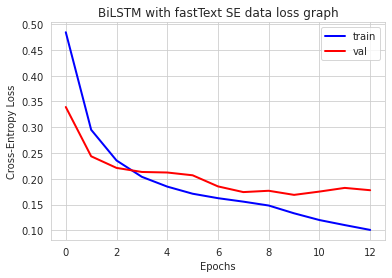

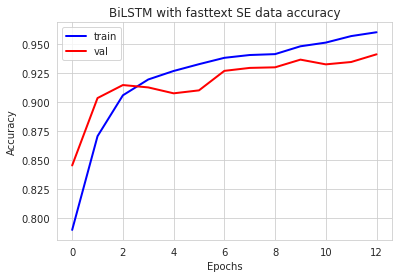

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1903
           1       0.73      0.98      0.83        54

    accuracy                           0.99      1957
   macro avg       0.86      0.99      0.91      1957
weighted avg       0.99      0.99      0.99      1957



In [16]:
count = 1

for train_index, test_index in kf.split(word_seq_train):
    x_trn, x_tst = word_seq_train[train_index], word_seq_train[test_index]
    y_trn, y_tst = y_train[train_index], y_train[test_index]
    
    x_new_train, x_val, y_new_train, y_val= train_test_split(x_trn, y_trn, test_size=0.11115, random_state=125)
    
    print("\nFold ", count)
    bilstm_model=BiLSTM()

    #model_lstm_fasttext=model_with_embedding()
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    
    history =bilstm_model.fit( x_new_train, y_new_train, batch_size=256,
          epochs=num_epochs, validation_data=(x_val, y_val), callbacks=[es_callback], shuffle=False)
    
    _, train_acc = bilstm_model.evaluate(x_new_train,  y_new_train, verbose=0)
    _, val_acc =  bilstm_model.evaluate(x_val, y_val, verbose=0)
    print('Train: %.3f, Test: %.3f' % (train_acc, val_acc))
    
    
    plt.figure()
    plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
    plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
    plt.title('BiLSTM with fastText SE data loss graph')
    plt.xlabel('Epochs')
    plt.ylabel('Cross-Entropy Loss')
    plt.legend(loc='upper right')
    #plt.savefig('LSTM with fasttext SE data loss graph.png')
    plt.show()
    
    plt.figure()
    plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
    plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
    plt.title('BiLSTM with fasttext SE data accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    #plt.savefig('LSTM with fasttext SE data accuracy graph.png')
    plt.show()
    
    
    y_pred = bilstm_model.predict(x_tst)
    y_pred = (y_pred >= 0.5)
 
    
    from sklearn import metrics
    print(metrics.classification_report(y_tst, y_pred))
    
    precision = precision_score(y_tst, y_pred, pos_label=1)
    recall = recall_score(y_tst, y_pred, pos_label=1)
    f1score = f1_score(y_tst, y_pred, pos_label=1)
    accuracy = accuracy_score(y_tst, y_pred)

    run_accuracy.append(accuracy)
    run_f1score.append(f1score)
    run_precision.append(precision)
    run_recall.append(recall)
    
    count = count+1

In [17]:
from statistics import mean
print("...........Score of BiLSTM..................")
print("     Precision", "         Recall   ", "       F-score        ", "    Accuracy")
print(mean(run_precision),mean(run_recall),mean(run_f1score),mean(run_accuracy))

...........Score of BiLSTM..................
     Precision          Recall           F-score             Accuracy
0.8163452989689638 0.8407576181998097 0.821545155181315 0.9348551309747936


In [18]:
maxlen = 43
embed_size = 300
max_features =16809
from keras.models import Model

from keras.layers import Dense, Input, LSTM,GlobalMaxPool1D
def Bi_LSTM_base():
    inp = keras.layers.Input(shape=(maxlen,))
    x = keras.layers.Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = keras.layers.Bidirectional(keras.layers.LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
    x = keras.layers.GlobalMaxPool1D()(x)
    x = keras.layers.Dense(50, activation="relu")(x)
    x = keras.layers.Dropout(0.1)(x)
    x = keras.layers.Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [19]:
Bi_LSTM_base().summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 43)                0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 43, 300)           5042700   
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 43, 100)           140400    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_12 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 51  

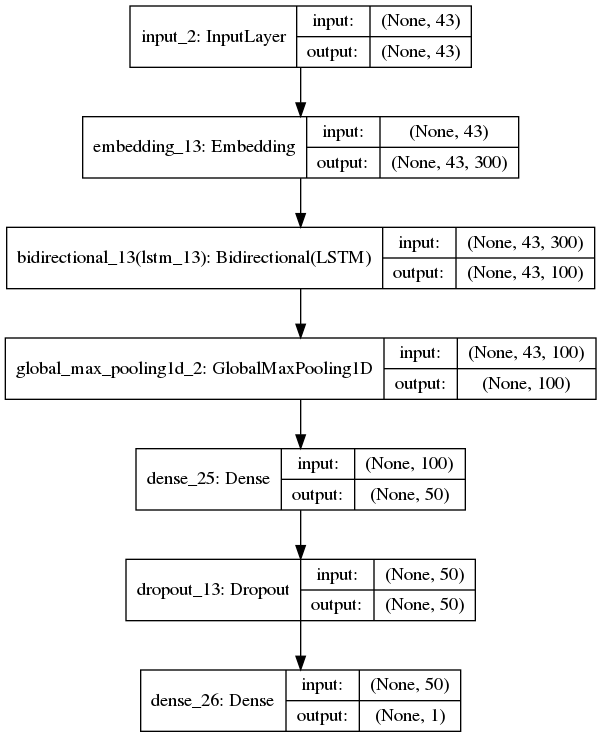

In [20]:
plot_model(Bi_LSTM_base(), to_file='BiLSTMbasemodel.png', show_shapes=True, show_layer_names=True)


In [21]:
blbase_run_precision = []
blbase_run_recall = []
blbase_run_f1score = []
blbase_run_accuracy = []


Fold  1


/home/amiangshu/anaconda3/envs/toxicJAY/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15655 samples, validate on 1958 samples
Epoch 1/40
15655/15655 [==============================] - 3s 198us/step - loss: 0.4164 - accuracy: 0.8247 - val_loss: 0.2392 - val_accuracy: 0.9173
Epoch 2/40
15655/15655 [==============================] - 2s 150us/step - loss: 0.1658 - accuracy: 0.9396 - val_loss: 0.1339 - val_accuracy: 0.9525
Epoch 3/40
15655/15655 [==============================] - 2s 149us/step - loss: 0.1019 - accuracy: 0.9646 - val_loss: 0.1151 - val_accuracy: 0.9622
Epoch 4/40
15655/15655 [==============================] - 2s 150us/step - loss: 0.0647 - accuracy: 0.9783 - val_loss: 0.1116 - val_accuracy: 0.9678
Epoch 5/40
15655/15655 [==============================] - 2s 150us/step - loss: 0.0425 - accuracy: 0.9874 - val_loss: 0.1156 - val_accuracy: 0.9714
Epoch 6/40
15655/15655 [==============================] - 2s 150us/step - loss: 0.0311 - accuracy: 0.9912 - val_loss: 0.1219 - val_accuracy: 0.9699
Epoch 7/40
15655/15655 [==============================] - 2s 15

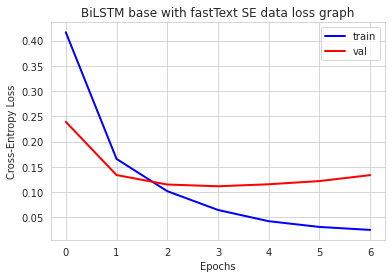

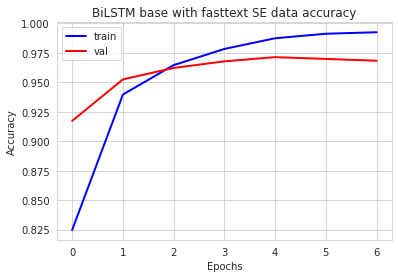

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1478
           1       0.79      0.75      0.77       480

    accuracy                           0.89      1958
   macro avg       0.85      0.84      0.85      1958
weighted avg       0.89      0.89      0.89      1958


Fold  2


/home/amiangshu/anaconda3/envs/toxicJAY/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15656 samples, validate on 1958 samples
Epoch 1/40
15656/15656 [==============================] - 3s 195us/step - loss: 0.4238 - accuracy: 0.8197 - val_loss: 0.2610 - val_accuracy: 0.9030
Epoch 2/40
15656/15656 [==============================] - 2s 147us/step - loss: 0.1702 - accuracy: 0.9354 - val_loss: 0.1404 - val_accuracy: 0.9540
Epoch 3/40
15656/15656 [==============================] - 2s 148us/step - loss: 0.1023 - accuracy: 0.9649 - val_loss: 0.1247 - val_accuracy: 0.9658
Epoch 4/40
15656/15656 [==============================] - 2s 148us/step - loss: 0.0631 - accuracy: 0.9800 - val_loss: 0.1155 - val_accuracy: 0.9612
Epoch 5/40
15656/15656 [==============================] - 2s 148us/step - loss: 0.0421 - accuracy: 0.9867 - val_loss: 0.1248 - val_accuracy: 0.9571
Epoch 6/40
15656/15656 [==============================] - 2s 148us/step - loss: 0.0318 - accuracy: 0.9906 - val_loss: 0.1471 - val_accuracy: 0.9622
Epoch 7/40
15656/15656 [==============================] - 2s 14

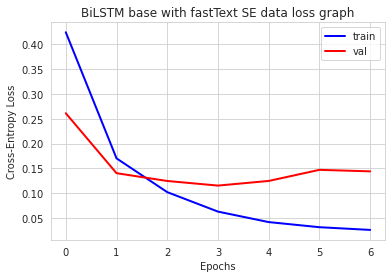

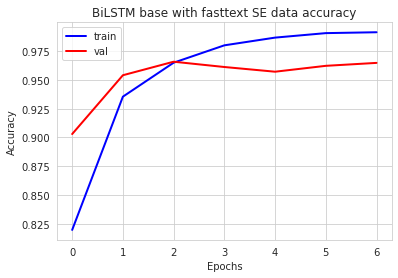

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1639
           1       0.73      0.70      0.72       318

    accuracy                           0.91      1957
   macro avg       0.84      0.83      0.83      1957
weighted avg       0.91      0.91      0.91      1957


Fold  3


/home/amiangshu/anaconda3/envs/toxicJAY/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15656 samples, validate on 1958 samples
Epoch 1/40
15656/15656 [==============================] - 3s 197us/step - loss: 0.4111 - accuracy: 0.8269 - val_loss: 0.2320 - val_accuracy: 0.9127
Epoch 2/40
15656/15656 [==============================] - 2s 150us/step - loss: 0.1579 - accuracy: 0.9402 - val_loss: 0.1297 - val_accuracy: 0.9510
Epoch 3/40
15656/15656 [==============================] - 2s 150us/step - loss: 0.0930 - accuracy: 0.9660 - val_loss: 0.1148 - val_accuracy: 0.9576
Epoch 4/40
15656/15656 [==============================] - 2s 150us/step - loss: 0.0547 - accuracy: 0.9823 - val_loss: 0.1097 - val_accuracy: 0.9607
Epoch 5/40
15656/15656 [==============================] - 2s 150us/step - loss: 0.0369 - accuracy: 0.9881 - val_loss: 0.1149 - val_accuracy: 0.9612
Epoch 6/40
15656/15656 [==============================] - 2s 150us/step - loss: 0.0281 - accuracy: 0.9906 - val_loss: 0.1240 - val_accuracy: 0.9658
Epoch 7/40
15656/15656 [==============================] - 2s 15

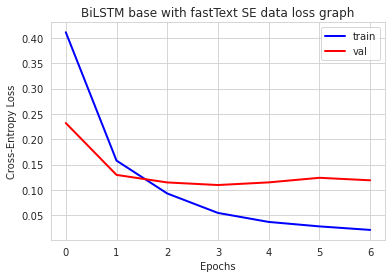

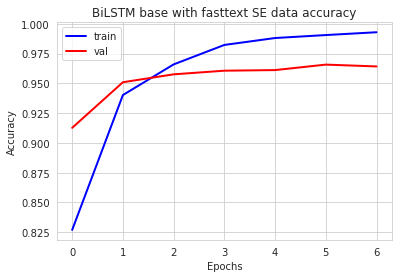

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1582
           1       0.65      0.67      0.66       375

    accuracy                           0.87      1957
   macro avg       0.79      0.79      0.79      1957
weighted avg       0.87      0.87      0.87      1957


Fold  4


/home/amiangshu/anaconda3/envs/toxicJAY/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15656 samples, validate on 1958 samples
Epoch 1/40
15656/15656 [==============================] - 3s 196us/step - loss: 0.4283 - accuracy: 0.8253 - val_loss: 0.2745 - val_accuracy: 0.8912
Epoch 2/40
15656/15656 [==============================] - 2s 151us/step - loss: 0.1803 - accuracy: 0.9307 - val_loss: 0.1391 - val_accuracy: 0.9530
Epoch 3/40
15656/15656 [==============================] - 2s 150us/step - loss: 0.1103 - accuracy: 0.9577 - val_loss: 0.1279 - val_accuracy: 0.9525
Epoch 4/40
15656/15656 [==============================] - 2s 150us/step - loss: 0.0714 - accuracy: 0.9745 - val_loss: 0.1325 - val_accuracy: 0.9540
Epoch 5/40
15656/15656 [==============================] - 2s 150us/step - loss: 0.0478 - accuracy: 0.9843 - val_loss: 0.1635 - val_accuracy: 0.9525
Epoch 6/40
15656/15656 [==============================] - 2s 150us/step - loss: 0.0395 - accuracy: 0.9862 - val_loss: 0.1713 - val_accuracy: 0.9499
Train: 0.993, Test: 0.950


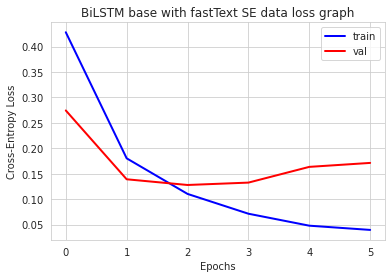

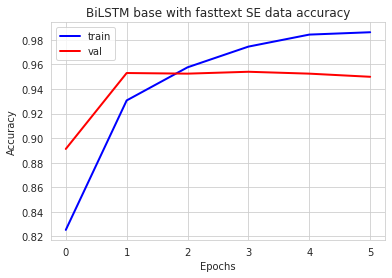

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1214
           1       0.92      0.93      0.92       743

    accuracy                           0.94      1957
   macro avg       0.94      0.94      0.94      1957
weighted avg       0.94      0.94      0.94      1957


Fold  5


/home/amiangshu/anaconda3/envs/toxicJAY/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15656 samples, validate on 1958 samples
Epoch 1/40
15656/15656 [==============================] - 3s 197us/step - loss: 0.4187 - accuracy: 0.8232 - val_loss: 0.2439 - val_accuracy: 0.9086
Epoch 2/40
15656/15656 [==============================] - 2s 151us/step - loss: 0.1731 - accuracy: 0.9327 - val_loss: 0.1491 - val_accuracy: 0.9464
Epoch 3/40
15656/15656 [==============================] - 2s 151us/step - loss: 0.1137 - accuracy: 0.9574 - val_loss: 0.1423 - val_accuracy: 0.9494
Epoch 4/40
15656/15656 [==============================] - 2s 150us/step - loss: 0.0738 - accuracy: 0.9734 - val_loss: 0.1519 - val_accuracy: 0.9443
Epoch 5/40
15656/15656 [==============================] - 2s 150us/step - loss: 0.0509 - accuracy: 0.9828 - val_loss: 0.1789 - val_accuracy: 0.9454
Epoch 6/40
15656/15656 [==============================] - 2s 152us/step - loss: 0.0356 - accuracy: 0.9886 - val_loss: 0.2074 - val_accuracy: 0.9438
Train: 0.993, Test: 0.944


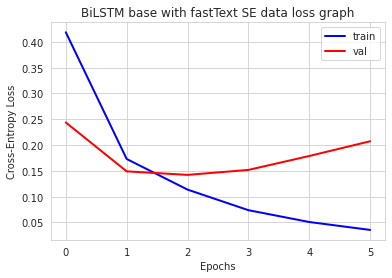

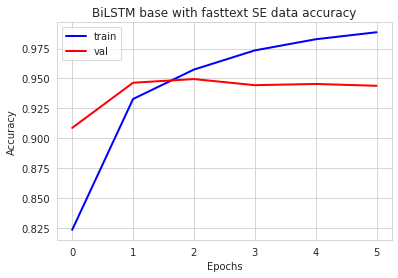

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1558
           1       0.99      0.94      0.96       399

    accuracy                           0.99      1957
   macro avg       0.99      0.97      0.98      1957
weighted avg       0.99      0.99      0.99      1957


Fold  6


/home/amiangshu/anaconda3/envs/toxicJAY/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15656 samples, validate on 1958 samples
Epoch 1/40
15656/15656 [==============================] - 3s 197us/step - loss: 0.4176 - accuracy: 0.8217 - val_loss: 0.2300 - val_accuracy: 0.9111
Epoch 2/40
15656/15656 [==============================] - 2s 150us/step - loss: 0.1766 - accuracy: 0.9329 - val_loss: 0.1500 - val_accuracy: 0.9448
Epoch 3/40
15656/15656 [==============================] - 2s 150us/step - loss: 0.1124 - accuracy: 0.9569 - val_loss: 0.1461 - val_accuracy: 0.9484
Epoch 4/40
15656/15656 [==============================] - 2s 150us/step - loss: 0.0753 - accuracy: 0.9728 - val_loss: 0.1510 - val_accuracy: 0.9484
Epoch 5/40
15656/15656 [==============================] - 2s 151us/step - loss: 0.0525 - accuracy: 0.9824 - val_loss: 0.1637 - val_accuracy: 0.9499
Epoch 6/40
15656/15656 [==============================] - 2s 151us/step - loss: 0.0391 - accuracy: 0.9874 - val_loss: 0.2094 - val_accuracy: 0.9479
Train: 0.992, Test: 0.948


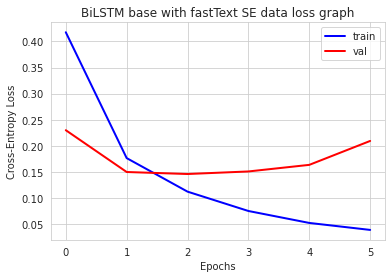

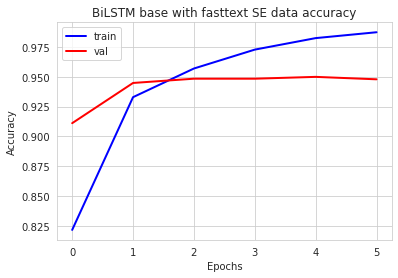

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1756
           1       0.97      0.95      0.96       201

    accuracy                           0.99      1957
   macro avg       0.98      0.97      0.98      1957
weighted avg       0.99      0.99      0.99      1957


Fold  7


/home/amiangshu/anaconda3/envs/toxicJAY/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15656 samples, validate on 1958 samples
Epoch 1/40
15656/15656 [==============================] - 3s 211us/step - loss: 0.4463 - accuracy: 0.8051 - val_loss: 0.3044 - val_accuracy: 0.8100
Epoch 2/40
15656/15656 [==============================] - 2s 151us/step - loss: 0.2030 - accuracy: 0.9155 - val_loss: 0.1491 - val_accuracy: 0.9454
Epoch 3/40
15656/15656 [==============================] - 2s 152us/step - loss: 0.1181 - accuracy: 0.9577 - val_loss: 0.1407 - val_accuracy: 0.9459
Epoch 4/40
15656/15656 [==============================] - 2s 152us/step - loss: 0.0773 - accuracy: 0.9741 - val_loss: 0.1572 - val_accuracy: 0.9448
Epoch 5/40
15656/15656 [==============================] - 2s 152us/step - loss: 0.0552 - accuracy: 0.9817 - val_loss: 0.1781 - val_accuracy: 0.9494
Epoch 6/40
15656/15656 [==============================] - 2s 152us/step - loss: 0.0430 - accuracy: 0.9852 - val_loss: 0.2009 - val_accuracy: 0.9510
Train: 0.989, Test: 0.951


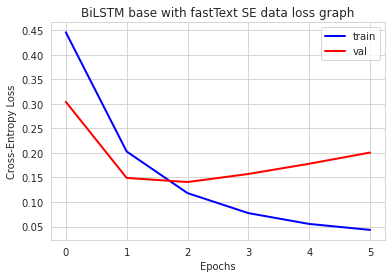

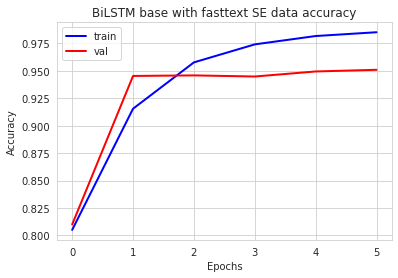

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1585
           1       0.95      0.93      0.94       372

    accuracy                           0.98      1957
   macro avg       0.97      0.96      0.96      1957
weighted avg       0.98      0.98      0.98      1957


Fold  8


/home/amiangshu/anaconda3/envs/toxicJAY/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15656 samples, validate on 1958 samples
Epoch 1/40
15656/15656 [==============================] - 3s 194us/step - loss: 0.4586 - accuracy: 0.7939 - val_loss: 0.3037 - val_accuracy: 0.8723
Epoch 2/40
15656/15656 [==============================] - 2s 147us/step - loss: 0.2011 - accuracy: 0.9204 - val_loss: 0.1536 - val_accuracy: 0.9448
Epoch 3/40
15656/15656 [==============================] - 2s 147us/step - loss: 0.1203 - accuracy: 0.9538 - val_loss: 0.1364 - val_accuracy: 0.9489
Epoch 4/40
15656/15656 [==============================] - 2s 147us/step - loss: 0.0776 - accuracy: 0.9730 - val_loss: 0.1459 - val_accuracy: 0.9484
Epoch 5/40
15656/15656 [==============================] - 2s 147us/step - loss: 0.0535 - accuracy: 0.9824 - val_loss: 0.1598 - val_accuracy: 0.9510
Epoch 6/40
15656/15656 [==============================] - 2s 147us/step - loss: 0.0403 - accuracy: 0.9875 - val_loss: 0.1689 - val_accuracy: 0.9515
Train: 0.993, Test: 0.951


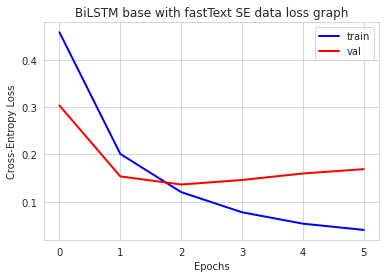

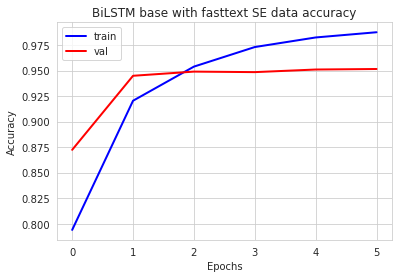

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1435
           1       0.99      0.98      0.98       522

    accuracy                           0.99      1957
   macro avg       0.99      0.99      0.99      1957
weighted avg       0.99      0.99      0.99      1957


Fold  9


/home/amiangshu/anaconda3/envs/toxicJAY/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15656 samples, validate on 1958 samples
Epoch 1/40
15656/15656 [==============================] - 3s 194us/step - loss: 0.4652 - accuracy: 0.7938 - val_loss: 0.2910 - val_accuracy: 0.8784
Epoch 2/40
15656/15656 [==============================] - 2s 147us/step - loss: 0.1968 - accuracy: 0.9229 - val_loss: 0.1544 - val_accuracy: 0.9428
Epoch 3/40
15656/15656 [==============================] - 2s 146us/step - loss: 0.1162 - accuracy: 0.9562 - val_loss: 0.1428 - val_accuracy: 0.9433
Epoch 4/40
15656/15656 [==============================] - 2s 147us/step - loss: 0.0765 - accuracy: 0.9718 - val_loss: 0.1604 - val_accuracy: 0.9372
Epoch 5/40
15656/15656 [==============================] - 2s 147us/step - loss: 0.0540 - accuracy: 0.9820 - val_loss: 0.1645 - val_accuracy: 0.9448
Epoch 6/40
15656/15656 [==============================] - ETA: 0s - loss: 0.0428 - accuracy: 0.98 - 2s 146us/step - loss: 0.0427 - accuracy: 0.9866 - val_loss: 0.1991 - val_accuracy: 0.9484
Train: 0.991, Test: 0

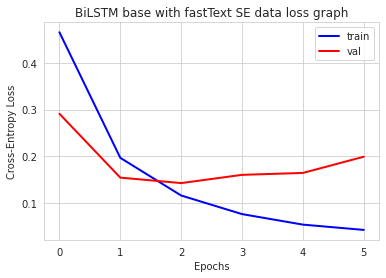

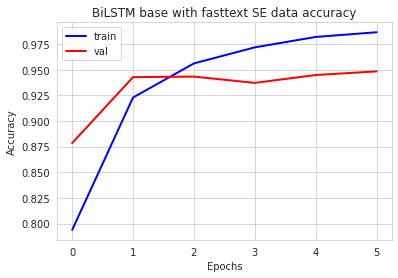

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1669
           1       0.99      0.93      0.96       288

    accuracy                           0.99      1957
   macro avg       0.99      0.97      0.98      1957
weighted avg       0.99      0.99      0.99      1957


Fold  10


/home/amiangshu/anaconda3/envs/toxicJAY/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15656 samples, validate on 1958 samples
Epoch 1/40
15656/15656 [==============================] - 3s 198us/step - loss: 0.4664 - accuracy: 0.7909 - val_loss: 0.2713 - val_accuracy: 0.8922
Epoch 2/40
15656/15656 [==============================] - 2s 151us/step - loss: 0.1936 - accuracy: 0.9249 - val_loss: 0.1621 - val_accuracy: 0.9438
Epoch 3/40
15656/15656 [==============================] - 2s 151us/step - loss: 0.1209 - accuracy: 0.9539 - val_loss: 0.1469 - val_accuracy: 0.9438
Epoch 4/40
15656/15656 [==============================] - 2s 151us/step - loss: 0.0770 - accuracy: 0.9724 - val_loss: 0.1619 - val_accuracy: 0.9387
Epoch 5/40
15656/15656 [==============================] - 2s 152us/step - loss: 0.0540 - accuracy: 0.9826 - val_loss: 0.1596 - val_accuracy: 0.9525
Epoch 6/40
15656/15656 [==============================] - 3s 162us/step - loss: 0.0409 - accuracy: 0.9865 - val_loss: 0.1857 - val_accuracy: 0.9505
Train: 0.992, Test: 0.950


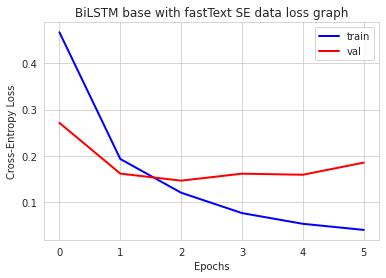

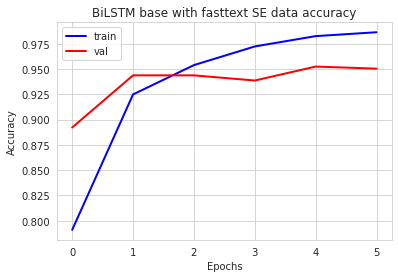

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1903
           1       0.93      0.98      0.95        54

    accuracy                           1.00      1957
   macro avg       0.96      0.99      0.98      1957
weighted avg       1.00      1.00      1.00      1957



In [22]:
count = 1

for train_index, test_index in kf.split(word_seq_train):
    x_trn, x_tst = word_seq_train[train_index], word_seq_train[test_index]
    y_trn, y_tst = y_train[train_index], y_train[test_index]
    
    x_new_train, x_val, y_new_train, y_val= train_test_split(x_trn, y_trn, test_size=0.11115, random_state=125)
    
    print("\nFold ", count)
    bilstmbase_model=Bi_LSTM_base()

    #model_lstm_fasttext=model_with_embedding()
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    
    history =bilstmbase_model.fit( x_new_train, y_new_train, batch_size=256,
          epochs=num_epochs, validation_data=(x_val, y_val), callbacks=[es_callback], shuffle=False)
    
    _, train_acc = bilstmbase_model.evaluate(x_new_train,  y_new_train, verbose=0)
    _, val_acc =  bilstmbase_model.evaluate(x_val, y_val, verbose=0)
    print('Train: %.3f, Test: %.3f' % (train_acc, val_acc))
    
    
    plt.figure()
    plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
    plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
    plt.title('BiLSTM base with fastText SE data loss graph')
    plt.xlabel('Epochs')
    plt.ylabel('Cross-Entropy Loss')
    plt.legend(loc='upper right')
    #plt.savefig('LSTM with fasttext SE data loss graph.png')
    plt.show()
    
    plt.figure()
    plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
    plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
    plt.title('BiLSTM base with fasttext SE data accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    #plt.savefig('LSTM with fasttext SE data accuracy graph.png')
    plt.show()
    
    
    y_pred = bilstmbase_model.predict(x_tst)
    y_pred = (y_pred >= 0.5)
 
    
    from sklearn import metrics
    print(metrics.classification_report(y_tst, y_pred))
    
    blbase_precision = precision_score(y_tst, y_pred, pos_label=1)
    blbase_recall = recall_score(y_tst, y_pred, pos_label=1)
    blbase_f1score = f1_score(y_tst, y_pred, pos_label=1)
    blbase_accuracy = accuracy_score(y_tst, y_pred)

    blbase_run_accuracy.append(blbase_accuracy)
    blbase_run_f1score.append(blbase_f1score)
    blbase_run_precision.append(blbase_precision)
    blbase_run_recall.append(blbase_recall)
    
    count = count+1

In [23]:
from statistics import mean
print("............... BiLSTM base ................")
print(".......Precision........", "........Recall........","........F1...........", ".....Accuracy.......")
print(mean(blbase_run_precision),mean(blbase_run_recall),mean(blbase_run_f1score),mean(blbase_run_accuracy))

............... BiLSTM base ................
.......Precision........ ........Recall........ ........F1........... .....Accuracy.......
0.8913839419380403 0.8765562907534249 0.8836509622306082 0.9542724240214666


In [24]:
#print(blbase_run_accuracy)

In [25]:
def get_model_PooledGRU():
    inp = keras.layers.Input(shape=(maxlen, ))
    x = keras.layers.Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = keras.layers.SpatialDropout1D(0.2)(x)
    x = keras.layers.Bidirectional(keras.layers.GRU(80, return_sequences=True))(x)
    avg_pool = keras.layers.GlobalAveragePooling1D()(x)
    max_pool = keras.layers.GlobalMaxPooling1D()(x)
    conc = keras.layers.concatenate([avg_pool, max_pool])
    outp = keras.layers.Dense(1, activation="sigmoid")(conc)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [26]:
get_model_PooledGRU().summary()


Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 43)           0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 43, 300)      5042700     input_13[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 43, 300)      0           embedding_24[0][0]               
__________________________________________________________________________________________________
bidirectional_24 (Bidirectional (None, 43, 160)      182880      spatial_dropout1d_1[0][0]        
___________________________________________________________________________________________

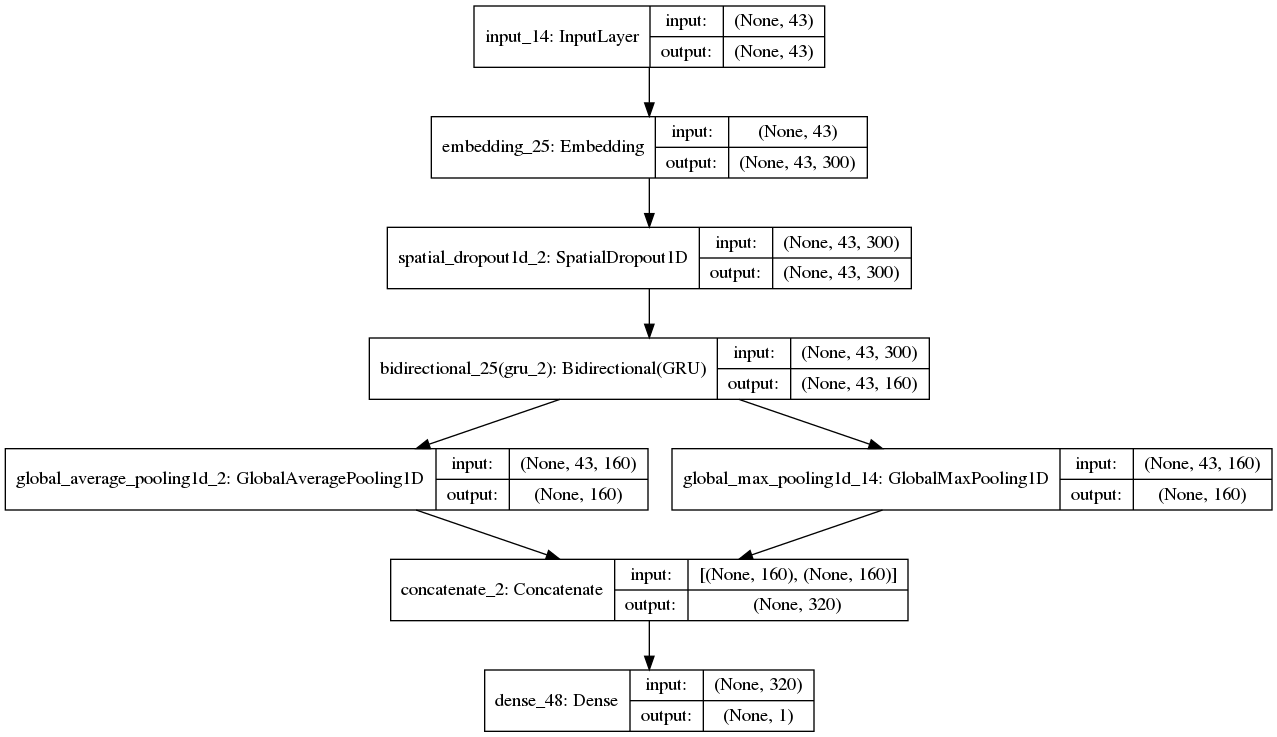

In [27]:
plot_model(get_model_PooledGRU(), to_file='GRUModel.png', show_shapes=True, show_layer_names=True)


In [28]:
gru_run_precision = []
gru_run_recall = []
gru_run_f1score = []
gru_run_accuracy = []


Fold  1


/home/amiangshu/anaconda3/envs/toxicJAY/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15655 samples, validate on 1958 samples
Epoch 1/40
15655/15655 [==============================] - 4s 225us/step - loss: 0.4054 - accuracy: 0.8137 - val_loss: 0.2159 - val_accuracy: 0.9213
Epoch 2/40
15655/15655 [==============================] - 3s 178us/step - loss: 0.1601 - accuracy: 0.9406 - val_loss: 0.1371 - val_accuracy: 0.9525
Epoch 3/40
15655/15655 [==============================] - 3s 177us/step - loss: 0.1096 - accuracy: 0.9588 - val_loss: 0.1215 - val_accuracy: 0.9556
Epoch 4/40
15655/15655 [==============================] - 3s 177us/step - loss: 0.0778 - accuracy: 0.9727 - val_loss: 0.1088 - val_accuracy: 0.9678
Epoch 5/40
15655/15655 [==============================] - 3s 178us/step - loss: 0.0524 - accuracy: 0.9831 - val_loss: 0.1091 - val_accuracy: 0.9673
Epoch 6/40
15655/15655 [==============================] - 3s 179us/step - loss: 0.0387 - accuracy: 0.9879 - val_loss: 0.1150 - val_accuracy: 0.9714
Epoch 7/40
15655/15655 [==============================] - 3s 18

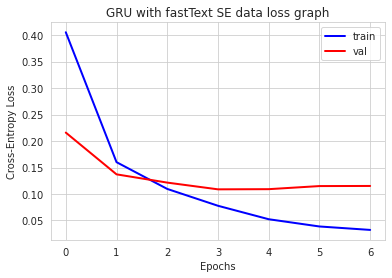

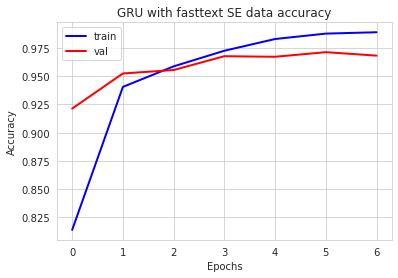

              precision    recall  f1-score   support

           0       0.93      0.92      0.93      1478
           1       0.77      0.77      0.77       480

    accuracy                           0.89      1958
   macro avg       0.85      0.85      0.85      1958
weighted avg       0.89      0.89      0.89      1958


Fold  2


/home/amiangshu/anaconda3/envs/toxicJAY/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15656 samples, validate on 1958 samples
Epoch 1/40
15656/15656 [==============================] - 3s 223us/step - loss: 0.3950 - accuracy: 0.8218 - val_loss: 0.2043 - val_accuracy: 0.9295
Epoch 2/40
15656/15656 [==============================] - 3s 176us/step - loss: 0.1596 - accuracy: 0.9385 - val_loss: 0.1356 - val_accuracy: 0.9520
Epoch 3/40
15656/15656 [==============================] - 3s 174us/step - loss: 0.1097 - accuracy: 0.9586 - val_loss: 0.1231 - val_accuracy: 0.9576
Epoch 4/40
15656/15656 [==============================] - 3s 176us/step - loss: 0.0760 - accuracy: 0.9730 - val_loss: 0.1162 - val_accuracy: 0.9612
Epoch 5/40
15656/15656 [==============================] - 3s 177us/step - loss: 0.0526 - accuracy: 0.9822 - val_loss: 0.1189 - val_accuracy: 0.9612
Epoch 6/40
15656/15656 [==============================] - 3s 175us/step - loss: 0.0426 - accuracy: 0.9863 - val_loss: 0.1197 - val_accuracy: 0.9612
Epoch 7/40
15656/15656 [==============================] - 3s 17

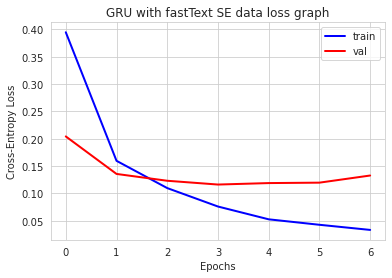

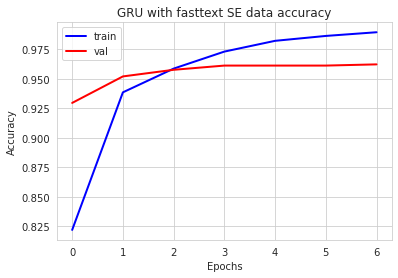

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1639
           1       0.78      0.65      0.71       318

    accuracy                           0.91      1957
   macro avg       0.85      0.81      0.83      1957
weighted avg       0.91      0.91      0.91      1957


Fold  3


/home/amiangshu/anaconda3/envs/toxicJAY/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15656 samples, validate on 1958 samples
Epoch 1/40
15656/15656 [==============================] - 3s 220us/step - loss: 0.3736 - accuracy: 0.8456 - val_loss: 0.1913 - val_accuracy: 0.9331
Epoch 2/40
15656/15656 [==============================] - 3s 174us/step - loss: 0.1524 - accuracy: 0.9407 - val_loss: 0.1309 - val_accuracy: 0.9530
Epoch 3/40
15656/15656 [==============================] - 3s 175us/step - loss: 0.1037 - accuracy: 0.9608 - val_loss: 0.1172 - val_accuracy: 0.9602
Epoch 4/40
15656/15656 [==============================] - 3s 175us/step - loss: 0.0685 - accuracy: 0.9757 - val_loss: 0.1155 - val_accuracy: 0.9597
Epoch 5/40
15656/15656 [==============================] - 3s 174us/step - loss: 0.0487 - accuracy: 0.9824 - val_loss: 0.1241 - val_accuracy: 0.9591
Epoch 6/40
15656/15656 [==============================] - 3s 175us/step - loss: 0.0349 - accuracy: 0.9882 - val_loss: 0.1280 - val_accuracy: 0.9658
Epoch 7/40
15656/15656 [==============================] - 3s 17

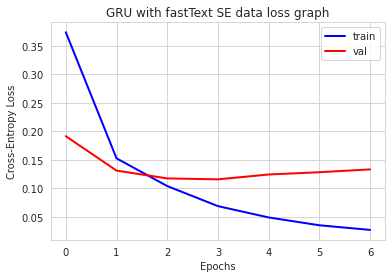

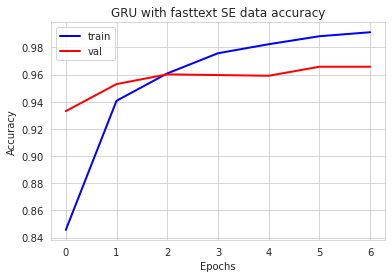

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1582
           1       0.74      0.65      0.69       375

    accuracy                           0.89      1957
   macro avg       0.83      0.80      0.81      1957
weighted avg       0.88      0.89      0.89      1957


Fold  4


/home/amiangshu/anaconda3/envs/toxicJAY/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15656 samples, validate on 1958 samples
Epoch 1/40
15656/15656 [==============================] - 3s 223us/step - loss: 0.3766 - accuracy: 0.8452 - val_loss: 0.2202 - val_accuracy: 0.9111
Epoch 2/40
15656/15656 [==============================] - 3s 175us/step - loss: 0.1612 - accuracy: 0.9372 - val_loss: 0.1400 - val_accuracy: 0.9499
Epoch 3/40
15656/15656 [==============================] - 3s 175us/step - loss: 0.1140 - accuracy: 0.9557 - val_loss: 0.1345 - val_accuracy: 0.9499
Epoch 4/40
15656/15656 [==============================] - 3s 174us/step - loss: 0.0815 - accuracy: 0.9687 - val_loss: 0.1388 - val_accuracy: 0.9510
Epoch 5/40
15656/15656 [==============================] - 3s 174us/step - loss: 0.0584 - accuracy: 0.9783 - val_loss: 0.1548 - val_accuracy: 0.9448
Epoch 6/40
15656/15656 [==============================] - 3s 174us/step - loss: 0.0459 - accuracy: 0.9844 - val_loss: 0.1644 - val_accuracy: 0.9515
Train: 0.991, Test: 0.951


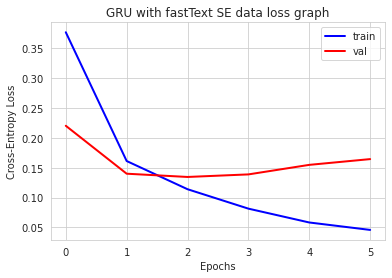

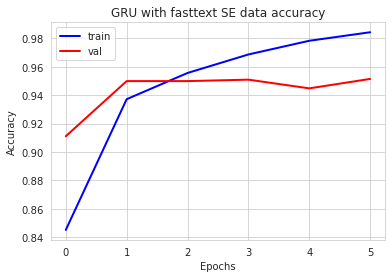

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1214
           1       0.93      0.92      0.92       743

    accuracy                           0.94      1957
   macro avg       0.94      0.94      0.94      1957
weighted avg       0.94      0.94      0.94      1957


Fold  5


/home/amiangshu/anaconda3/envs/toxicJAY/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15656 samples, validate on 1958 samples
Epoch 1/40
15656/15656 [==============================] - 3s 222us/step - loss: 0.3881 - accuracy: 0.8311 - val_loss: 0.2109 - val_accuracy: 0.9208
Epoch 2/40
15656/15656 [==============================] - 3s 176us/step - loss: 0.1706 - accuracy: 0.9334 - val_loss: 0.1444 - val_accuracy: 0.9489
Epoch 3/40
15656/15656 [==============================] - 3s 175us/step - loss: 0.1228 - accuracy: 0.9513 - val_loss: 0.1379 - val_accuracy: 0.9479
Epoch 4/40
15656/15656 [==============================] - 3s 175us/step - loss: 0.0870 - accuracy: 0.9683 - val_loss: 0.1447 - val_accuracy: 0.9448
Epoch 5/40
15656/15656 [==============================] - 3s 176us/step - loss: 0.0606 - accuracy: 0.9773 - val_loss: 0.1590 - val_accuracy: 0.9454
Epoch 6/40
15656/15656 [==============================] - 3s 175us/step - loss: 0.0480 - accuracy: 0.9834 - val_loss: 0.1860 - val_accuracy: 0.9474
Train: 0.991, Test: 0.947


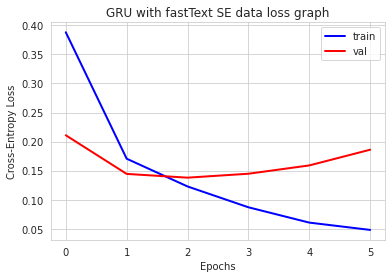

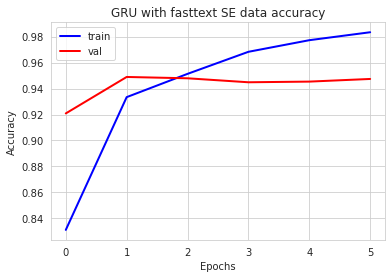

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1558
           1       0.98      0.95      0.96       399

    accuracy                           0.99      1957
   macro avg       0.98      0.97      0.98      1957
weighted avg       0.99      0.99      0.99      1957


Fold  6


/home/amiangshu/anaconda3/envs/toxicJAY/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15656 samples, validate on 1958 samples
Epoch 1/40
15656/15656 [==============================] - 3s 221us/step - loss: 0.3893 - accuracy: 0.8346 - val_loss: 0.2100 - val_accuracy: 0.9178
Epoch 2/40
15656/15656 [==============================] - 3s 174us/step - loss: 0.1697 - accuracy: 0.9317 - val_loss: 0.1521 - val_accuracy: 0.9408
Epoch 3/40
15656/15656 [==============================] - 3s 175us/step - loss: 0.1239 - accuracy: 0.9520 - val_loss: 0.1420 - val_accuracy: 0.9454
Epoch 4/40
15656/15656 [==============================] - 3s 176us/step - loss: 0.0903 - accuracy: 0.9666 - val_loss: 0.1389 - val_accuracy: 0.9448
Epoch 5/40
15656/15656 [==============================] - 3s 175us/step - loss: 0.0687 - accuracy: 0.9746 - val_loss: 0.1498 - val_accuracy: 0.9418
Epoch 6/40
15656/15656 [==============================] - 3s 174us/step - loss: 0.0502 - accuracy: 0.9829 - val_loss: 0.1673 - val_accuracy: 0.9438
Epoch 7/40
15656/15656 [==============================] - 3s 17

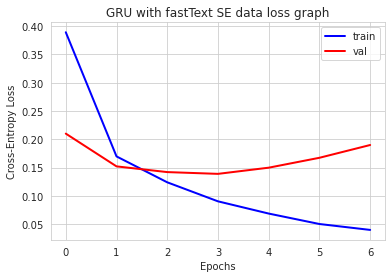

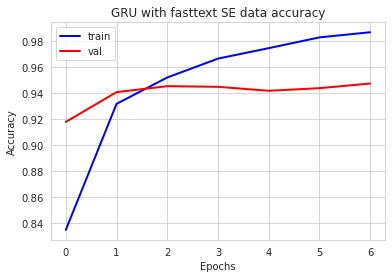

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1756
           1       0.98      0.96      0.97       201

    accuracy                           0.99      1957
   macro avg       0.99      0.98      0.98      1957
weighted avg       0.99      0.99      0.99      1957


Fold  7


/home/amiangshu/anaconda3/envs/toxicJAY/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15656 samples, validate on 1958 samples
Epoch 1/40
15656/15656 [==============================] - 3s 222us/step - loss: 0.3926 - accuracy: 0.8263 - val_loss: 0.2070 - val_accuracy: 0.9193
Epoch 2/40
15656/15656 [==============================] - 3s 183us/step - loss: 0.1681 - accuracy: 0.9355 - val_loss: 0.1417 - val_accuracy: 0.9499
Epoch 3/40
15656/15656 [==============================] - 3s 187us/step - loss: 0.1206 - accuracy: 0.9534 - val_loss: 0.1371 - val_accuracy: 0.9479
Epoch 4/40
15656/15656 [==============================] - 3s 183us/step - loss: 0.0885 - accuracy: 0.9667 - val_loss: 0.1385 - val_accuracy: 0.9459
Epoch 5/40
15656/15656 [==============================] - 3s 176us/step - loss: 0.0648 - accuracy: 0.9760 - val_loss: 0.1548 - val_accuracy: 0.9479
Epoch 6/40
15656/15656 [==============================] - 3s 178us/step - loss: 0.0469 - accuracy: 0.9833 - val_loss: 0.1761 - val_accuracy: 0.9510
Train: 0.991, Test: 0.951


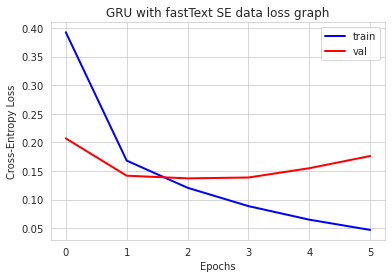

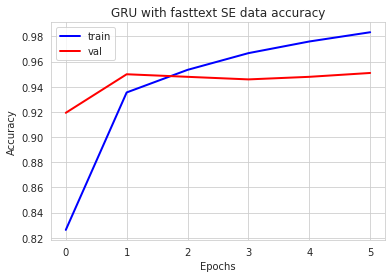

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1585
           1       0.95      0.95      0.95       372

    accuracy                           0.98      1957
   macro avg       0.97      0.97      0.97      1957
weighted avg       0.98      0.98      0.98      1957


Fold  8


/home/amiangshu/anaconda3/envs/toxicJAY/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15656 samples, validate on 1958 samples
Epoch 1/40
15656/15656 [==============================] - 3s 221us/step - loss: 0.3856 - accuracy: 0.8327 - val_loss: 0.2064 - val_accuracy: 0.9208
Epoch 2/40
15656/15656 [==============================] - 3s 175us/step - loss: 0.1700 - accuracy: 0.9329 - val_loss: 0.1445 - val_accuracy: 0.9448
Epoch 3/40
15656/15656 [==============================] - 3s 174us/step - loss: 0.1226 - accuracy: 0.9515 - val_loss: 0.1335 - val_accuracy: 0.9505
Epoch 4/40
15656/15656 [==============================] - 3s 175us/step - loss: 0.0914 - accuracy: 0.9653 - val_loss: 0.1438 - val_accuracy: 0.9448
Epoch 5/40
15656/15656 [==============================] - 3s 175us/step - loss: 0.0642 - accuracy: 0.9773 - val_loss: 0.1559 - val_accuracy: 0.9397
Epoch 6/40
15656/15656 [==============================] - 3s 175us/step - loss: 0.0501 - accuracy: 0.9823 - val_loss: 0.1645 - val_accuracy: 0.9474
Train: 0.991, Test: 0.947


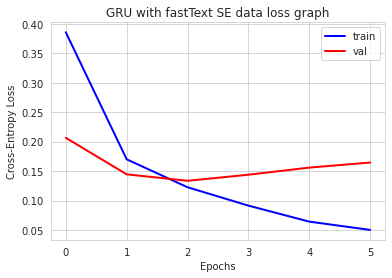

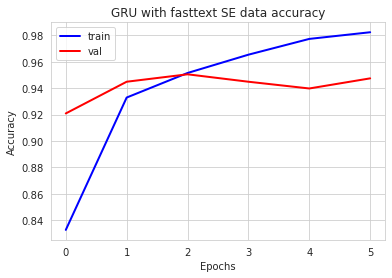

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1435
           1       0.97      0.97      0.97       522

    accuracy                           0.98      1957
   macro avg       0.98      0.98      0.98      1957
weighted avg       0.98      0.98      0.98      1957


Fold  9


/home/amiangshu/anaconda3/envs/toxicJAY/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15656 samples, validate on 1958 samples
Epoch 1/40
15656/15656 [==============================] - 3s 221us/step - loss: 0.4025 - accuracy: 0.8223 - val_loss: 0.2195 - val_accuracy: 0.9127
Epoch 2/40
15656/15656 [==============================] - 3s 175us/step - loss: 0.1736 - accuracy: 0.9318 - val_loss: 0.1515 - val_accuracy: 0.9459
Epoch 3/40
15656/15656 [==============================] - 3s 174us/step - loss: 0.1213 - accuracy: 0.9522 - val_loss: 0.1453 - val_accuracy: 0.9438
Epoch 4/40
15656/15656 [==============================] - 3s 175us/step - loss: 0.0879 - accuracy: 0.9674 - val_loss: 0.1460 - val_accuracy: 0.9413
Epoch 5/40
15656/15656 [==============================] - 3s 174us/step - loss: 0.0641 - accuracy: 0.9774 - val_loss: 0.1493 - val_accuracy: 0.9428
Epoch 6/40
15656/15656 [==============================] - 3s 174us/step - loss: 0.0536 - accuracy: 0.9821 - val_loss: 0.1568 - val_accuracy: 0.9515
Train: 0.990, Test: 0.951


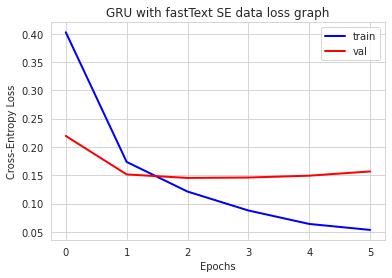

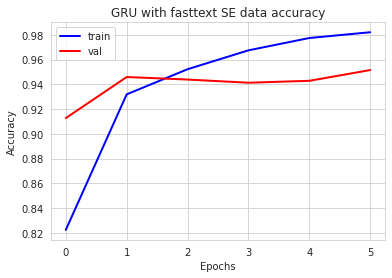

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1669
           1       0.98      0.94      0.96       288

    accuracy                           0.99      1957
   macro avg       0.99      0.97      0.98      1957
weighted avg       0.99      0.99      0.99      1957


Fold  10


/home/amiangshu/anaconda3/envs/toxicJAY/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15656 samples, validate on 1958 samples
Epoch 1/40
15656/15656 [==============================] - 4s 225us/step - loss: 0.3972 - accuracy: 0.8266 - val_loss: 0.2102 - val_accuracy: 0.9193
Epoch 2/40
15656/15656 [==============================] - 3s 177us/step - loss: 0.1726 - accuracy: 0.9325 - val_loss: 0.1541 - val_accuracy: 0.9423
Epoch 3/40
15656/15656 [==============================] - 3s 176us/step - loss: 0.1251 - accuracy: 0.9515 - val_loss: 0.1495 - val_accuracy: 0.9438
Epoch 4/40
15656/15656 [==============================] - 3s 178us/step - loss: 0.0907 - accuracy: 0.9681 - val_loss: 0.1510 - val_accuracy: 0.9423
Epoch 5/40
15656/15656 [==============================] - 3s 177us/step - loss: 0.0656 - accuracy: 0.9777 - val_loss: 0.1705 - val_accuracy: 0.9402
Epoch 6/40
15656/15656 [==============================] - 3s 177us/step - loss: 0.0526 - accuracy: 0.9815 - val_loss: 0.1699 - val_accuracy: 0.9515
Train: 0.988, Test: 0.951


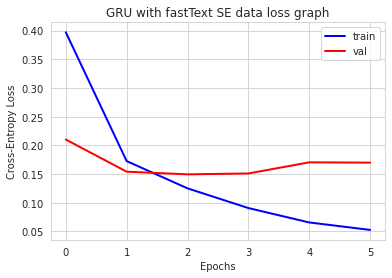

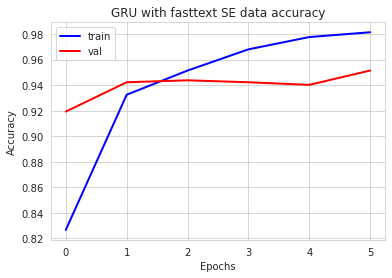

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1903
           1       0.93      0.93      0.93        54

    accuracy                           1.00      1957
   macro avg       0.96      0.96      0.96      1957
weighted avg       1.00      1.00      1.00      1957



In [29]:
count = 1

for train_index, test_index in kf.split(word_seq_train):
    x_trn, x_tst = word_seq_train[train_index], word_seq_train[test_index]
    y_trn, y_tst = y_train[train_index], y_train[test_index]
    
    x_new_train, x_val, y_new_train, y_val= train_test_split(x_trn, y_trn, test_size=0.11115, random_state=125)
    
    print("\nFold ", count)
    gru_model=get_model_PooledGRU()

    #model_lstm_fasttext=model_with_embedding()
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    
    history =gru_model.fit( x_new_train, y_new_train, batch_size=256,
          epochs=num_epochs, validation_data=(x_val, y_val), callbacks=[es_callback], shuffle=False)
    
    _, train_acc =gru_model.evaluate(x_new_train,  y_new_train, verbose=0)
    _, val_acc =  gru_model.evaluate(x_val, y_val, verbose=0)
    print('Train: %.3f, Test: %.3f' % (train_acc, val_acc))
    
    
    plt.figure()
    plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
    plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
    plt.title('GRU with fastText SE data loss graph')
    plt.xlabel('Epochs')
    plt.ylabel('Cross-Entropy Loss')
    plt.legend(loc='upper right')
    #plt.savefig('LSTM with fasttext SE data loss graph.png')
    plt.show()
    
    plt.figure()
    plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
    plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
    plt.title('GRU with fasttext SE data accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    #plt.savefig('LSTM with fasttext SE data accuracy graph.png')
    plt.show()
    
    
    y_pred = gru_model.predict(x_tst)
    y_pred = (y_pred >= 0.5)
 
    
    from sklearn import metrics
    print(metrics.classification_report(y_tst, y_pred))
    
    gru_precision = precision_score(y_tst, y_pred, pos_label=1)
    gru_recall = recall_score(y_tst, y_pred, pos_label=1)
    gru_f1score = f1_score(y_tst, y_pred, pos_label=1)
    gru_accuracy = accuracy_score(y_tst, y_pred)

    gru_run_accuracy.append(gru_accuracy)
    gru_run_f1score.append(gru_f1score)
    gru_run_precision.append(gru_precision)
    gru_run_recall.append(gru_recall)
    
    count = count+1

In [30]:
from statistics import mean
print("....... GRU Model................")
print(".......Precision........", "........Recall........","........F1...........", ".....Accuracy.......")

print(mean(gru_run_precision),mean(gru_run_recall),mean(gru_run_f1score),mean(gru_run_accuracy))

....... GRU Model................
.......Precision........ ........Recall........ ........F1........... .....Accuracy.......
0.8992702730738443 0.8689765598232174 0.8832551917141361 0.9558565595439853


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_36 (Embedding)     (None, 43, 300)           5042700   
_________________________________________________________________
dropout_24 (Dropout)         (None, 43, 300)           0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 43, 300)           721200    
_________________________________________________________________
flatten_1 (Flatten)          (None, 12900)             0         
_________________________________________________________________
dense_59 (Dense)             (None, 512)               6605312   
_________________________________________________________________
dropout_25 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_60 (Dense)             (None, 8)               

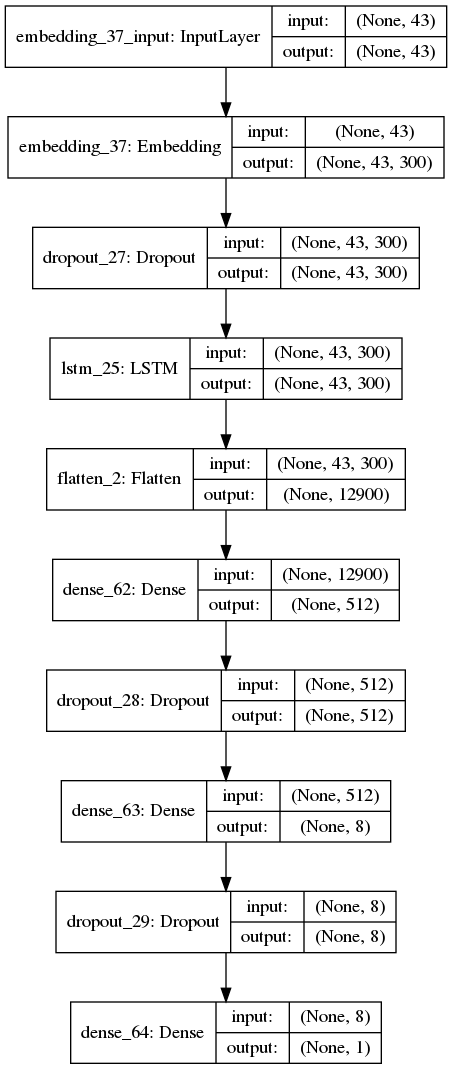


Fold  1
Train on 15655 samples, validate on 1958 samples
Epoch 1/40
15655/15655 [==============================] - 2s 151us/step - loss: 2.8721 - accuracy: 0.8168 - val_loss: 1.8279 - val_accuracy: 0.8529
Epoch 2/40
15655/15655 [==============================] - 2s 115us/step - loss: 1.7134 - accuracy: 0.8475 - val_loss: 1.5242 - val_accuracy: 0.8856
Epoch 3/40
15655/15655 [==============================] - 2s 115us/step - loss: 1.4924 - accuracy: 0.8617 - val_loss: 1.3352 - val_accuracy: 0.9025
Epoch 4/40
15655/15655 [==============================] - 2s 116us/step - loss: 1.3230 - accuracy: 0.8720 - val_loss: 1.1695 - val_accuracy: 0.9219
Epoch 5/40
15655/15655 [==============================] - 2s 118us/step - loss: 1.1744 - accuracy: 0.8827 - val_loss: 1.0380 - val_accuracy: 0.9285
Epoch 6/40
15655/15655 [==============================] - 2s 116us/step - loss: 1.0572 - accuracy: 0.8895 - val_loss: 0.9235 - val_accuracy: 0.9285
Epoch 7/40
15655/15655 [==============================

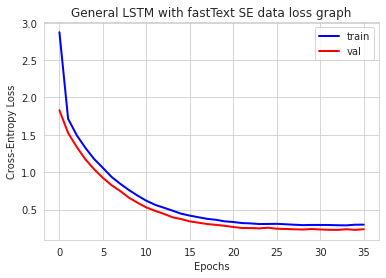

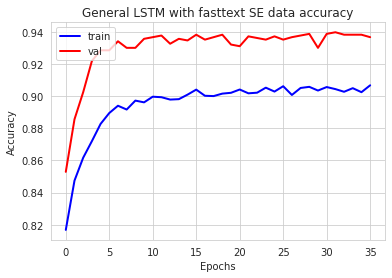

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      1478
           1       0.78      0.75      0.76       480

    accuracy                           0.89      1958
   macro avg       0.85      0.84      0.84      1958
weighted avg       0.89      0.89      0.89      1958


Fold  2
Train on 15656 samples, validate on 1958 samples
Epoch 1/40
15656/15656 [==============================] - 2s 146us/step - loss: 2.8723 - accuracy: 0.8119 - val_loss: 1.8316 - val_accuracy: 0.8672
Epoch 2/40
15656/15656 [==============================] - 2s 115us/step - loss: 1.7277 - accuracy: 0.8560 - val_loss: 1.5394 - val_accuracy: 0.8943
Epoch 3/40
15656/15656 [==============================] - 2s 115us/step - loss: 1.5190 - accuracy: 0.8708 - val_loss: 1.3801 - val_accuracy: 0.9132
Epoch 4/40
15656/15656 [==============================] - 2s 116us/step - loss: 1.3468 - accuracy: 0.8852 - val_loss: 1.1842 - val_accuracy: 0.9244
Epoch 5/40
15656/15656 

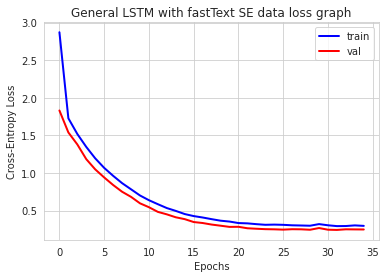

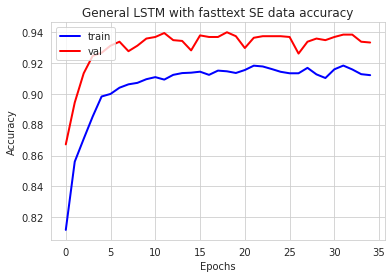

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1639
           1       0.75      0.64      0.69       318

    accuracy                           0.91      1957
   macro avg       0.84      0.80      0.82      1957
weighted avg       0.90      0.91      0.90      1957


Fold  3
Train on 15656 samples, validate on 1958 samples
Epoch 1/40
15656/15656 [==============================] - 2s 148us/step - loss: 2.9386 - accuracy: 0.8295 - val_loss: 1.8662 - val_accuracy: 0.8616
Epoch 2/40
15656/15656 [==============================] - 2s 114us/step - loss: 1.7373 - accuracy: 0.8564 - val_loss: 1.5679 - val_accuracy: 0.8759
Epoch 3/40
15656/15656 [==============================] - 2s 113us/step - loss: 1.5070 - accuracy: 0.8680 - val_loss: 1.3659 - val_accuracy: 0.9081
Epoch 4/40
15656/15656 [==============================] - 2s 114us/step - loss: 1.3320 - accuracy: 0.8802 - val_loss: 1.2051 - val_accuracy: 0.9162
Epoch 5/40
15656/15656 

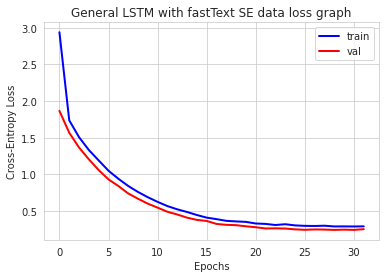

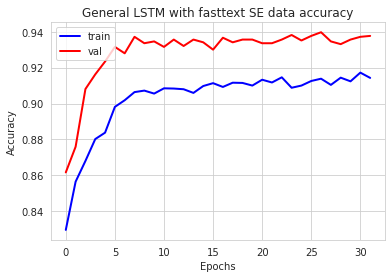

              precision    recall  f1-score   support

           0       0.92      0.95      0.94      1582
           1       0.77      0.63      0.69       375

    accuracy                           0.89      1957
   macro avg       0.84      0.79      0.82      1957
weighted avg       0.89      0.89      0.89      1957


Fold  4
Train on 15656 samples, validate on 1958 samples
Epoch 1/40
15656/15656 [==============================] - 2s 150us/step - loss: 2.8987 - accuracy: 0.8350 - val_loss: 1.8571 - val_accuracy: 0.8820
Epoch 2/40
15656/15656 [==============================] - 2s 118us/step - loss: 1.7152 - accuracy: 0.8579 - val_loss: 1.5363 - val_accuracy: 0.8861
Epoch 3/40
15656/15656 [==============================] - 2s 117us/step - loss: 1.4893 - accuracy: 0.8730 - val_loss: 1.3536 - val_accuracy: 0.9065
Epoch 4/40
15656/15656 [==============================] - 2s 117us/step - loss: 1.3170 - accuracy: 0.8890 - val_loss: 1.1974 - val_accuracy: 0.9152
Epoch 5/40
15656/15656 

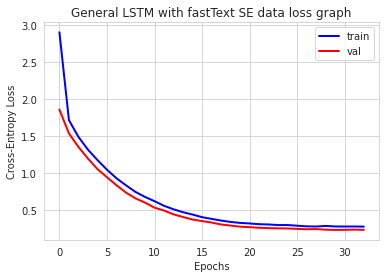

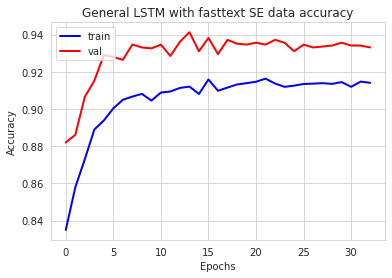

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1214
           1       0.84      0.84      0.84       743

    accuracy                           0.88      1957
   macro avg       0.87      0.87      0.87      1957
weighted avg       0.88      0.88      0.88      1957


Fold  5
Train on 15656 samples, validate on 1958 samples
Epoch 1/40
15656/15656 [==============================] - 2s 147us/step - loss: 2.8750 - accuracy: 0.8058 - val_loss: 1.8339 - val_accuracy: 0.8350
Epoch 2/40
15656/15656 [==============================] - 2s 128us/step - loss: 1.7131 - accuracy: 0.8470 - val_loss: 1.5434 - val_accuracy: 0.8713
Epoch 3/40
15656/15656 [==============================] - 2s 130us/step - loss: 1.5090 - accuracy: 0.8672 - val_loss: 1.3555 - val_accuracy: 0.8922
Epoch 4/40
15656/15656 [==============================] - 2s 127us/step - loss: 1.3446 - accuracy: 0.8750 - val_loss: 1.2055 - val_accuracy: 0.9132
Epoch 5/40
15656/15656 

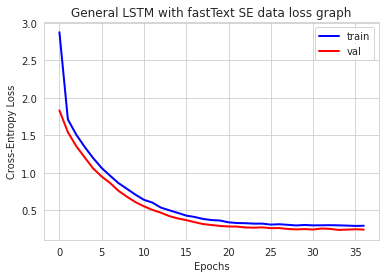

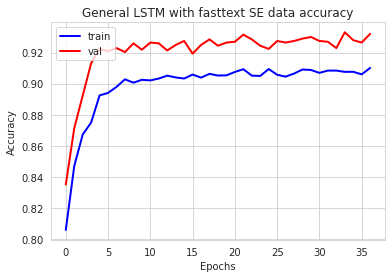

              precision    recall  f1-score   support

           0       0.94      0.99      0.97      1558
           1       0.95      0.77      0.85       399

    accuracy                           0.94      1957
   macro avg       0.95      0.88      0.91      1957
weighted avg       0.94      0.94      0.94      1957


Fold  6
Train on 15656 samples, validate on 1958 samples
Epoch 1/40
15656/15656 [==============================] - 2s 142us/step - loss: 2.8893 - accuracy: 0.8139 - val_loss: 1.8297 - val_accuracy: 0.8514
Epoch 2/40
15656/15656 [==============================] - 2s 107us/step - loss: 1.7398 - accuracy: 0.8480 - val_loss: 1.5511 - val_accuracy: 0.8774
Epoch 3/40
15656/15656 [==============================] - 2s 107us/step - loss: 1.5253 - accuracy: 0.8588 - val_loss: 1.3790 - val_accuracy: 0.8963
Epoch 4/40
15656/15656 [==============================] - 2s 112us/step - loss: 1.3499 - accuracy: 0.8786 - val_loss: 1.2136 - val_accuracy: 0.9019
Epoch 5/40
15656/15656 

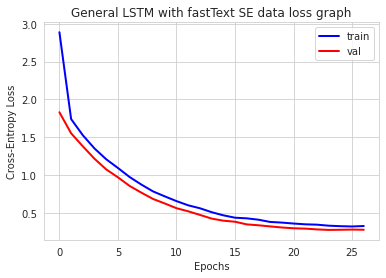

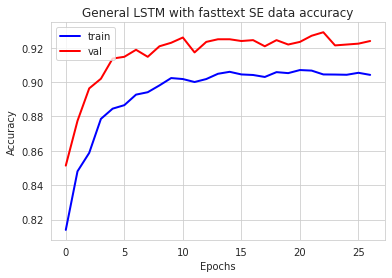

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1756
           1       0.87      0.78      0.82       201

    accuracy                           0.97      1957
   macro avg       0.92      0.88      0.90      1957
weighted avg       0.96      0.97      0.96      1957


Fold  7
Train on 15656 samples, validate on 1958 samples
Epoch 1/40
15656/15656 [==============================] - 2s 143us/step - loss: 2.9375 - accuracy: 0.8226 - val_loss: 1.8460 - val_accuracy: 0.8687
Epoch 2/40
15656/15656 [==============================] - 2s 113us/step - loss: 1.7392 - accuracy: 0.8535 - val_loss: 1.5306 - val_accuracy: 0.8927
Epoch 3/40
15656/15656 [==============================] - 2s 110us/step - loss: 1.5213 - accuracy: 0.8693 - val_loss: 1.3743 - val_accuracy: 0.8917
Epoch 4/40
15656/15656 [==============================] - 2s 113us/step - loss: 1.3421 - accuracy: 0.8823 - val_loss: 1.1946 - val_accuracy: 0.9132
Epoch 5/40
15656/15656 

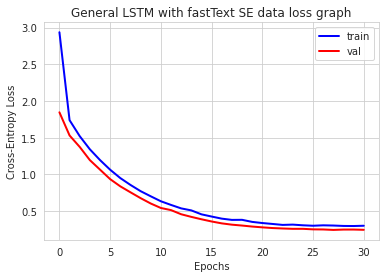

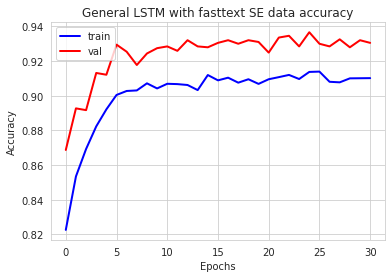

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1585
           1       0.83      0.80      0.82       372

    accuracy                           0.93      1957
   macro avg       0.89      0.88      0.89      1957
weighted avg       0.93      0.93      0.93      1957


Fold  8
